## README
- Se hicieron todas las actividades.
- Tuve problemas con los graficos en la ultima parte porque el runtime se me desconectaba constantemente (por problemas de conexion - COVID )

Fuentes de insipiracion y base para los modelos/procesamiento utilizado:
- https://github.com/bentrevett/pytorch-sentiment-analysis
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#training-and-evaluating (Este lo encontre en el paper que se referencia en el SCAN DATASET)

# Parte 1 (RNN)

## Def RNN

In [ ]:
 
import torch
import torch.nn as nn
 
class RNN(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = output_dim

    # Agregamos un embedding como entrada a la RNN. 
    self.embedding = nn.Embedding(input_dim,embedding_dim)

    # A diferencia del Modulo presentado en el enunciado, no se usa batch first en este modulo.
    # Es decir las dimensiones son (largo, batch_size)
    self.rnn = nn.RNN(embedding_dim, hidden_dim)

    self.linear_out = nn.Linear(hidden_dim, 1)
  def forward(self, input):
    #text = [sent len, batch size]
    
    embedded = self.embedding(input)
    
    #embedded = [sent len, batch size, emb dim]
    
    output, hidden = self.rnn(embedded)
    
    #output = [sent len, batch size, hid dim]
    #hidden = [1, batch size, hid dim]
    assert torch.equal(output[-1,:,:], hidden.squeeze(0))
      
    return self.linear_out(hidden.squeeze(0))
  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    return hidden
 
def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def list_trainable_parameters(model):
  return [p.numel() for p in model.parameters() if p.requires_grad]


In [ ]:
from torchtext import data, datasets

TEXT = data.Field(lower=True,tokenize='spacy')
## include_lengths = true para user padded sequences
LABEL=  data.LabelField(dtype=torch.float)
train,test = datasets.IMDB.splits(TEXT,LABEL)


aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 39.5MB/s]


In [ ]:
import random
SEED=1
train, validation = train.split(random_state = random.seed(SEED))

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, validation, test), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train,vectors='glove.6B.100d',max_size= MAX_VOCAB_SIZE,unk_init=torch.Tensor.normal_,min_freq=10)
LABEL.build_vocab(train)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                          
100%|█████████▉| 399178/400000 [00:25<00:00, 15167.46it/s]

In [ ]:
len(TEXT.vocab)

17357

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 1

# Agregamos a matriz de pesos el embedding pre-entrenado de GloVe
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


num_trainable_parameters(model)


1756001

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)


## Actividad 1
(Respuesta Pregunta 1)
- Si se aumenta el tamaño de las oraciones, se podria tomar la decision de modificiar el modelo (capas ocultas) para que se adapte de mejor manera. 
- Si aumenta el numero de palabras en el diccionario, cambiaria el Embedding y por lo tanto el numero de parametros. 
- Si el dataset se mantiene con el mismo largo de palabras y oraciones, es decir solo aumenta el tamaño en filas. Es el unico caso donde no cambiarian los numeros de parametros.
(Respuesta Pregunta 2)
- Disminuyendo el numero de palabras en el diccionario y por lo tanto en el embedding. 
- Disminuyendo el largo de las oraciones
- Obtener solo el 95% de palabras mas frequentes por ejemplo. En esta tarea se elimino las palabras que tenian una frecuencia menor a 10 para eliminar correos o palabras mal escritas.  Esto reduce el numero de parametros



In [ ]:
num_trainable_parameters(model) ## hidden = 100

1756001

In [ ]:
list_trainable_parameters(model) ## hidden =100

[1735700, 10000, 10000, 100, 100, 100, 1]

In [ ]:
num_trainable_parameters(model) ## hidden = 50

1756001

In [ ]:
list_trainable_parameters(model) # hidden = 50

[1735700, 10000, 10000, 100, 100, 100, 1]

(Respuesta Pregunta 3)

Podemos ver la descomposicion de los parametros entrenables:

``[(Embedding),(Wxh RNN), (Whh RNN), (W_y RNN),(Bias RNN) (W LinearNN) , (Bias Linear NN)] ``

*  Podemos ver que el numero de parametros entrenables para ``hidden_dim = 100`` es de ``1756001``
* Cuando modificamos este a 50, tenemos ``1743351`` parametros entrenables. Una diferencia de 12650 la cual se descompone en:[link text](https://)
- El embedding se mantiene en 1735700
- Los pesos 50 x 100 antes eran 100 x 100 representan los Wxh (delta=5000)
- Los siguientes pesos 50 x 50 antes eran 100 x 100 representan los Whh (delta=7500)
- El siguiente es el Wyh del output que ahora tiene dimension 50
 y no 100 (delta=50)
- El siguente es el bias de la RNN que cambia proporicional al numero de hidden states.(delta=50)
-  El siguiente es cada peso de la LinearNN para cada hidden state (delta=50)
- Por ultimo, el LinearNN  tiene 1 bias que no cambia. (delta=0)

Por lo tanto:
`5000+7500+50+50+50=12650`

In [ ]:
def train_model(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train **RNN**

In [ ]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.693 | Train Acc: 51.16%
	 Val. Loss: 0.692 |  Val. Acc: 51.42%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.692 | Train Acc: 52.14%
	 Val. Loss: 0.691 |  Val. Acc: 52.59%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.691 | Train Acc: 52.56%
	 Val. Loss: 0.691 |  Val. Acc: 53.05%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.691 | Train Acc: 52.73%
	 Val. Loss: 0.690 |  Val. Acc: 53.29%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.690 | Train Acc: 53.09%
	 Val. Loss: 0.689 |  Val. Acc: 54.41%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.689 | Train Acc: 53.63%
	 Val. Loss: 0.688 |  Val. Acc: 54.82%
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.687 | Train Acc: 55.16%
	 Val. Loss: 0.685 |  Val. Acc: 55.70%
Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.683 | Train Acc: 56.27%
	 Val. Loss: 0.679 |  Val. Acc: 57.34%
Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.667 | Train Acc: 59.80%
	 Val. Loss: 0.680 |  Val. Acc: 56.29%
Epoch: 10 | Epoch Time: 0m 4

In [ ]:
best_valid_loss

0.6363853332349809

In [ ]:
model.load_state_dict(torch.load('RNN-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.638 | Test Acc: 65.07%


## Actividad 2


### Def Bidirectional RNN

In [ ]:
import torch
import torch.nn as nn
 
class BiRNN(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = output_dim

    # Agregamos un embedding como entrada a la RNN. 
    self.embedding = nn.Embedding(input_dim,embedding_dim)

    # A diferencia del Modulo presentado en el enunciado, no se usa batch first en este modulo.
    # Es decir las dimensiones son (largo, batch_size)
    # bidireectional para agregar la capa y hacerla bidireccional
    self.rnn = nn.RNN(embedding_dim, hidden_dim,bidirectional=True)
    
    self.linear_out = nn.Linear(hidden_dim, 1)
    
  def forward(self, input):
    #text = [sent len, batch size]
    
    embedded = self.embedding(input)
    
    #embedded = [sent len, batch size, emb dim]
    
    output, hidden = self.rnn(embedded)
    
    #output = [sent len, batch size, hid dim]
    #hidden = [1, batch size, hid dim]
    
    # assert torch.equal(output[-1,:,:], hidden.squeeze(2))
    # hidden = hidden.view(hidden.size(0)*hidden.size(1), self.hidden_dim*2)
    out= hidden[-2,:,:]+hidden[-1,:,:]
    return self.linear_out(out)
  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    return hidden

In [ ]:
import torch.optim as optim

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 1

# Agregamos a matriz de pesos el embedding pre-entrenado de GloVe
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model = BiRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


num_trainable_parameters(model)


optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

### Train BiRNN

In [ ]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BiRNN-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.695 | Train Acc: 50.17%
	 Val. Loss: 0.691 |  Val. Acc: 52.31%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.690 | Train Acc: 53.01%
	 Val. Loss: 0.687 |  Val. Acc: 55.00%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.687 | Train Acc: 54.86%
	 Val. Loss: 0.683 |  Val. Acc: 56.77%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.684 | Train Acc: 55.57%
	 Val. Loss: 0.680 |  Val. Acc: 57.67%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.681 | Train Acc: 56.88%
	 Val. Loss: 0.678 |  Val. Acc: 58.21%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.678 | Train Acc: 58.21%
	 Val. Loss: 0.673 |  Val. Acc: 59.09%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.673 | Train Acc: 59.25%
	 Val. Loss: 0.667 |  Val. Acc: 59.79%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.665 | Train Acc: 60.20%
	 Val. Loss: 0.669 |  Val. Acc: 59.02%
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.651 | Train Acc: 62.59%
	 Val. Loss: 0.653 |  Val. Acc: 60.95%
Epoch: 10 | Epoch Time: 0m 7

In [ ]:
model.load_state_dict(torch.load('BiRNN-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.573 | Test Acc: 70.64%


### Def DenseBidirectional RNN

In [ ]:
import torch
import torch.nn as nn
 
class DenseBiRNN(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = output_dim

    # Agregamos un embedding como entrada a la RNN. 
    self.embedding = nn.Embedding(input_dim,embedding_dim)

    # A diferencia del Modulo presentado en el enunciado, no se usa batch first en este modulo.
    # Es decir las dimensiones son (largo, batch_size)
    # bidireectional para agregar la capa y hacerla bidireccional
    self.rnn = nn.RNN(embedding_dim, hidden_dim,bidirectional=True)
    self.dense = nn.Linear(hidden_dim,100)
    self.linear_out = nn.Linear(100, 1)
    
  def forward(self, input):
    #text = [sent len, batch size]
    
    embedded = self.embedding(input)
    
    #embedded = [sent len, batch size, emb dim]
    
    output, hidden = self.rnn(embedded)
    
    #output = [sent len, batch size, hid dim]
    #hidden = [1, batch size, hid dim]
    
    # assert torch.equal(output[-1,:,:], hidden.squeeze(2))
    # hidden = hidden.view(hidden.size(0)*hidden.size(1), self.hidden_dim*2)
    out= hidden[-2,:,:]+hidden[-1,:,:]
    return self.linear_out(out)
  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    return hidden

In [ ]:
import torch.optim as optim

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 1

# Agregamos a matriz de pesos el embedding pre-entrenado de GloVe
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model = DenseBiRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


num_trainable_parameters(model)


optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)


### Train DenseBiRNN

In [ ]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'DenseBiRNN-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.626 | Train Acc: 65.61%
	 Val. Loss: 0.705 |  Val. Acc: 52.95%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.630 | Train Acc: 64.99%
	 Val. Loss: 0.604 |  Val. Acc: 67.64%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.643 | Train Acc: 63.23%
	 Val. Loss: 0.672 |  Val. Acc: 58.88%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.669 | Train Acc: 59.09%
	 Val. Loss: 0.670 |  Val. Acc: 58.69%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.666 | Train Acc: 59.49%
	 Val. Loss: 0.666 |  Val. Acc: 59.60%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.662 | Train Acc: 60.12%
	 Val. Loss: 0.661 |  Val. Acc: 60.57%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.657 | Train Acc: 60.87%
	 Val. Loss: 0.657 |  Val. Acc: 61.33%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.649 | Train Acc: 61.85%
	 Val. Loss: 0.645 |  Val. Acc: 63.25%
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.642 | Train Acc: 62.80%
	 Val. Loss: 0.634 |  Val. Acc: 63.57%
Epoch: 10 | Epoch Time: 0m 7

In [ ]:
model.load_state_dict(torch.load('DenseBiRNN-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.543 | Test Acc: 72.73%


### Respuesta Actividad

Se use vectores GloVe para inicializar los vectores en el Embedding

- BiRNN: Se vario el tamaño de los embeddings y se obtuvo mejores resultados con un embedding de 100
- DenseBiRNN: Es el BiRNN + Capa dense extra en la salida.
- Velocidad de convergencia(Menor a mayor): RNN -> BiRNN -> DenseBiRNN
- Resultados (Menor a mayor accuracy): RNN -> BiRNN -> DenseBiRNN

Se puede ver que agregarle la bidireccionalidad aumenta la complejidad del modelo pero representa de mejor manera el sentimiento de las oraciones. 
Lo mismo se puede decir de la capa densa extra, esta capa extra de pesos entrega mayor contexto al resolver el sentimiento de la oracion.

## Actividad 3

### Def LSTM 

In [ ]:
## https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb

import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        
        output_lengths, (hidden, cell) = self.rnn(embedded)
        
        #unpack sequence

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)



In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

num_trainable_parameters(model)

4046357

### Train LSTM

In [ ]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LSTM-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



Epoch: 01 | Epoch Time: 1m 33s
	Train Loss: 0.686 | Train Acc: 55.11%
	 Val. Loss: 0.695 |  Val. Acc: 49.01%
Epoch: 02 | Epoch Time: 1m 33s
	Train Loss: 0.692 | Train Acc: 53.08%
	 Val. Loss: 0.685 |  Val. Acc: 56.29%
Epoch: 03 | Epoch Time: 1m 33s
	Train Loss: 0.691 | Train Acc: 52.82%
	 Val. Loss: 0.685 |  Val. Acc: 54.63%
Epoch: 04 | Epoch Time: 1m 33s
	Train Loss: 0.687 | Train Acc: 54.86%
	 Val. Loss: 0.678 |  Val. Acc: 56.77%
Epoch: 05 | Epoch Time: 1m 33s
	Train Loss: 0.672 | Train Acc: 58.26%
	 Val. Loss: 0.630 |  Val. Acc: 64.33%
Epoch: 06 | Epoch Time: 1m 33s
	Train Loss: 0.627 | Train Acc: 65.45%
	 Val. Loss: 0.506 |  Val. Acc: 75.37%
Epoch: 07 | Epoch Time: 1m 33s
	Train Loss: 0.529 | Train Acc: 74.12%
	 Val. Loss: 0.395 |  Val. Acc: 82.45%
Epoch: 08 | Epoch Time: 1m 33s
	Train Loss: 0.417 | Train Acc: 81.39%
	 Val. Loss: 0.320 |  Val. Acc: 86.45%
Epoch: 09 | Epoch Time: 1m 33s
	Train Loss: 0.366 | Train Acc: 84.17%
	 Val. Loss: 0.328 |  Val. Acc: 86.75%
Epoch: 10 | Epoch T

In [ ]:
model.load_state_dict(torch.load('LSTM-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.259 | Test Acc: 89.72%


### Respuesta Actividad 3

- Cada epoch es mas largo con LSTM. (Mas parametros que entrener)
- Los resultados son significamente mejores. Es un LSTM bidireccional, pero la diferencia con el RNN bidireccional es de `70%` a `89.72%`. Un gran salto de accuraccy.
- Mejoro considerablemente la prediccion con LSTM. El problema de gradiente ya no esta afectando la red como en RNN clasico.


# Parte 2

## Pre-processing

In [ ]:
!wget https://raw.githubusercontent.com/brendenlake/SCAN/master/simple_split/tasks_train_simple.txt

--2020-06-10 02:30:31--  https://raw.githubusercontent.com/brendenlake/SCAN/master/simple_split/tasks_train_simple.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3267938 (3.1M) [text/plain]
Saving to: ‘tasks_train_simple.txt.1’

tasks_train_simple. 100%[===================>]   3.12M  --.-KB/s    in 0.09s   

2020-06-10 02:30:33 (34.4 MB/s) - ‘tasks_train_simple.txt.1’ saved [3267938/3267938]



In [ ]:
!wget https://raw.githubusercontent.com/brendenlake/SCAN/master/simple_split/tasks_test_simple.txt

--2020-06-10 02:30:35--  https://raw.githubusercontent.com/brendenlake/SCAN/master/simple_split/tasks_test_simple.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812450 (793K) [text/plain]
Saving to: ‘tasks_test_simple.txt.1’

tasks_test_simple.t 100%[===================>] 793.41K  --.-KB/s    in 0.05s   

2020-06-10 02:30:35 (16.1 MB/s) - ‘tasks_test_simple.txt.1’ saved [812450/812450]



In [ ]:
!pip install torchtext

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        self.max_s_len =-1
    def addSentence(self, sentence):
        self.updateMax(sentence)
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    def updateMax(self,sentence):
        stce_len=len(sentence.split(" "))
        if(stce_len>self.max_s_len):
          self.max_s_len =stce_len

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_human, pair[0])
    target_tensor = tensorFromSentence(output_machine, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
train = None
with open('tasks_train_simple.txt') as train_file:
  train = train_file.readlines()
test = None
with open('tasks_test_simple.txt') as test_file:
  test = test_file.readlines()


## Limpieza y separar labeles
def get_values_labels(data):
  pairs=[]
  for row in data:
    IN,OUT=row.split("OUT: ")
    IN = IN.strip("IN: ")
    OUT = OUT.strip()
    pairs.append([IN,OUT])
  return pairs


## Guardamos nuestro dataset de train y test
pairs = get_values_labels(train)
test_pairs = get_values_labels(test)

def prepare_data(pairs):
  input_human = Lang('human')
  output_machine = Lang('machine')
  for pair in pairs:
    input_human.addSentence(pair[0])
    output_machine.addSentence(pair[1])
  print(input_human.name,input_human.n_words)
  print(output_machine.name,output_machine.n_words)
  return input_human,output_machine,pairs
    
input_human,output_machine,pairs = prepare_data(pairs)
MAX_LENGTH = max(input_human.max_s_len,output_machine.max_s_len)
tensorFromSentence(input_human,random.choice(pairs)[0])

human 15
machine 8


tensor([[ 7],
        [13],
        [ 4],
        [ 5],
        [ 6],
        [ 2],
        [13],
        [ 4],
        [ 8],
        [ 1]], device='cuda:0')

##  Def Encoder & Decoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output,hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden,cell_states):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
          #  decoder_output, decoder_hidden, decoder_attention = decoder(
          #       decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden  = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # decoder_output, decoder_hidden, decoder_attention = decoder(
            #     decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


def test(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        # decoder_output, decoder_hidden, decoder_attention = decoder(
        #     decoder_input, decoder_hidden, encoder_outputs)
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=5, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_human, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # decoder_output, decoder_hidden, decoder_attention = decoder(
            #   decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_machine.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()


        # return decoded_words, decoder_attentions[:di + 1]
        l = len(decoded_words)
        
        return decoded_words

In [ ]:
def testIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    testing_pairs = [tensorsFromPair(random.choice(test_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    for iter in range(1, n_iters + 1):
        testing_pair = testing_pairs[iter - 1]
        input_tensor = testing_pair[0]
        target_tensor = testing_pair[1]
        print(target_tensor.shape)
        print(input_tensor.shape)
        loss = test(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses,print_loss_total

In [ ]:

def acc_score(pred_tags,trgs):
  WRONG_WORD ="<FOOBAR>"
  final_score=0 
  for t in range(len(pred_tags)):
    pred = pred_tags[t]
    correct = trgs[t]
    len_pred = len(pred)
    len_correct = len(correct)
    if len_correct > len_pred:
      pred+=[WRONG_WORD]*(len_correct - len_pred)
    elif len_correct < len_pred:
      pred = pred[:len_correct]
    assert len(correct)==len(pred)
    score = sum([pred[i]==correct[i] for i in range(len(correct))])/len(correct)
    final_score += score
  return final_score/len(pred_tags)
def calculate_score(data, encoder, decoder, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = datum[0]
        trg = datum[1]
        
        pred_trg = evaluate(encoder,decoder,src)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append(trg)
    return acc_score(pred_trgs, trgs)

## RUN without attention

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_human.n_words, hidden_size).to(device)
attn_decoder1 = DecoderRNN(hidden_size, output_machine.n_words).to(device)
num_trainable_parameters(encoder1)+num_trainable_parameters(attn_decoder1)

797448

### Actividad 4
- Tiene `797448` parametros entrenables
- Vocabulario de origen (Humano) tiene 15
- Vocabulario de destino (Machine) tiene 8

In [ ]:


all_loss = trainIters(encoder1, attn_decoder1, 16728, 100)
print(all_loss)
showPlot(all_loss)

0m 3s (- 8m 41s) (100 0%) 2.6187
0m 5s (- 7m 12s) (200 1%) 2.2566
0m 7s (- 6m 34s) (300 1%) 1.7689
0m 9s (- 6m 17s) (400 2%) 1.6305
0m 11s (- 6m 7s) (500 2%) 1.7668
0m 13s (- 5m 57s) (600 3%) 1.4824
0m 15s (- 5m 52s) (700 4%) 1.2745
0m 17s (- 5m 48s) (800 4%) 1.3726
0m 19s (- 5m 37s) (900 5%) 1.1633
0m 21s (- 5m 35s) (1000 5%) 1.2777
0m 23s (- 5m 30s) (1100 6%) 1.1427
0m 25s (- 5m 30s) (1200 7%) 1.0631
0m 27s (- 5m 27s) (1300 7%) 1.1620
0m 29s (- 5m 26s) (1400 8%) 1.0853
0m 31s (- 5m 23s) (1500 8%) 1.0203
0m 33s (- 5m 20s) (1600 9%) 0.9244
0m 36s (- 5m 18s) (1700 10%) 1.0757
0m 38s (- 5m 15s) (1800 10%) 1.0717
0m 40s (- 5m 12s) (1900 11%) 1.1056
0m 42s (- 5m 9s) (2000 11%) 0.9450
0m 44s (- 5m 8s) (2100 12%) 1.1041
0m 46s (- 5m 5s) (2200 13%) 1.0473
0m 48s (- 5m 2s) (2300 13%) 1.0014
0m 50s (- 5m 0s) (2400 14%) 0.9732
0m 52s (- 4m 57s) (2500 14%) 1.1199
0m 54s (- 4m 55s) (2600 15%) 0.9586
0m 56s (- 4m 52s) (2700 16%) 0.9516
0m 58s (- 4m 50s) (2800 16%) 1.0309
1m 0s (- 4m 47s) (2900 17%)

In [ ]:
sample_ = evaluate(encoder1,attn_decoder1,'jump and look')
sample_

In [ ]:
a=[2.1251753966013593, 2.027854638452883, 3.5990879822480224, 3.059693857206331, 2.947558057480964, 4.091440056700672, 3.514751228084409, 2.7133286644280035, 3.192299522600676, 2.44098979826055, 2.9186287286542507, 2.2487886873881022, 2.4705661675080077, 2.090898203575748, 2.254079335665513, 1.8820935351885608, 2.146207951434582, 2.078600005119566, 1.496847604680027, 3.0745057779947915, 2.8452856966807714, 2.5844064719412985, 2.7622156698830658, 2.581594910805556, 2.5044883472750885, 1.9934921135947452, 2.549298523974472, 2.856054189553232, 1.9471914443775868, 1.9848427549997965, 1.7455112401783075, 2.1660040820542203, 2.379735743522644, 1.707810012795664, 2.2648841465646603, 2.3957414165678474, 1.7219295542697186, 1.8327857988914218, 2.006806371284253, 2.3014052531695124, 1.9599262068006726, 1.578425352611239, 1.5404843575613842, 1.8063242610703167, 1.9525529479458978, 1.4889641305109933, 1.235554483628701, 1.7768328469140187, 1.7393059474882822, 1.5203928968641491, 2.1144351597746613, 1.6084750128020509, 2.079467740891472, 1.5751382424386495, 1.9525639120271936, 1.7417472722249001, 2.1256899743551734, 1.9647572113741922, 1.9407996701726258, 1.6768864024943149, 1.916727415999474, 1.631958499484592, 1.7818859994769531, 1.9069248830841334, 1.8433211803675296, 1.9282149521904048, 1.553498426104674, 1.4918289154570425, 1.8189344804642826, 1.6708603363291783, 1.6420778003296295, 1.5349307162550745, 1.5025810781151356, 1.562763229480658, 1.7390584819840345, 1.5806901438756298, 1.3942500337793136, 1.384502962542704, 1.2607983985779776, 1.464964332113733, 1.227173854055859, 2.059944771206568, 1.2698712387992273, 1.6567241094584453, 1.7997123201525838, 1.9579010366005871, 1.7730349026739343, 1.5674815559387207, 1.39238235629551, 1.2736448518667536, 1.27005260820742, 1.5327375856908416, 1.9572945611698405, 1.4346885839945962, 1.985425484897645, 1.7274698724994413, 3.0387809040995726, 2.5173951193341297, 1.447582625112704, 2.447567685724615, 1.6356533163279174, 1.5401003157786834, 1.2359025102673156, 1.1314101156424652, 1.669171435273191, 1.6893897906216708, 1.2121462603152058, 2.0395121847959983, 1.6702206449035715, 1.7598946681669734, 1.7628217584658892, 1.6527270233191225, 1.3593632243092204, 1.4128882334782529, 1.2774829150528562, 1.3431005428906968, 1.3215150248264682, 1.469371985178145, 1.301234737206331, 1.1646981974137134, 1.2150821451835192, 1.251123976759858, 1.3505206533420964, 1.0303070044721294, 1.5467802921597495, 1.6737582419708545, 0.946289395682723, 1.4385652831106477, 1.0359780271217307, 1.3999874651690065, 1.44986900705119, 1.0797510534619525, 1.2037705350805212, 1.4065666839790594, 0.7784075221138046, 1.2730747544570957, 1.477841083348146, 1.3827062309029614, 1.1751564861214614, 1.3741202148593918, 1.8516965125245126, 1.0405401994554375, 1.2854762397135109, 1.7531018780629875, 1.2102044253774724, 1.3284922918709376, 1.2435696377713454, 1.2140554103806855, 1.6055988944586432, 1.0146971689039659, 1.371391884653412, 1.3490642975116596, 1.2190251152603715, 1.6194179114403084, 1.3760951464364672, 1.4568997642441923, 1.7248545361629894, 1.3636726837431656, 0.9236172592278683, 1.50074640424628, 1.123097399331473, 1.163681669634314, 1.285932528259408, 1.3079006419203798, 1.01903559366862, 1.5068225239813147, 0.9997935816287498, 1.0402463964806559, 1.3679855473836262, 1.0912390796220297, 1.3440152625635522, 0.8306896007162893, 1.0405373634830597, 1.177933540646992, 1.0057934884671813, 1.130434942942091, 1.116748049853843, 1.235207146345967, 1.2583230471873024, 1.2204294331931314, 0.9246789156339685, 1.4419188586148348, 1.0357182287895816, 1.3287770756399049, 1.0507599280972788, 1.2987086895983335, 1.3824914152801235, 1.473289464522099, 1.1729368073865252, 1.2715678230587975, 1.0683165460244204, 1.2505033470335463, 1.3846185282298498, 1.0268910418981794, 1.2547269935731764, 1.07378856196548, 1.18053015110376, 1.5587681875822745, 2.0206319297576605, 1.3552379979080569, 1.039293288706538, 1.0115304191907246, 0.944309271298922, 1.4331790288049515, 1.1312495474691517, 1.1595714701925004, 1.4171073312090154, 0.9665982299433761, 1.0663202057839696, 1.1213785113389658, 1.4728091996985597, 1.0862739523337306, 1.6337928672063917, 0.9470005655172253, 1.1021473229177492, 1.081369357881092, 0.8197647034433659, 1.1542925223437224, 0.8731663229643416, 1.3931097333748024, 1.0721013722758, 0.6638658273170841, 0.7608136823908023, 0.8756716049399842, 0.9497727950414022, 0.9113243287906311, 0.6536943951720904, 1.1028917595587253, 0.7232882201971442, 1.9788356819848896, 1.0709099416567511, 0.9064628323179562, 1.277446445423736, 1.169979394502915, 1.2359370218300005, 1.620533264024246, 0.956543171591758, 1.148019897479729, 1.3857606809567184, 0.7975829105150132, 1.011940628544131, 1.0973080847599939, 1.3343619569633844, 1.2695276165008544, 1.490174523685575, 1.1723635114930633, 1.191151231877944, 1.3166456337270325, 1.2477420126271044, 0.9384031500823227, 1.0630247668025614, 0.8437846893551704, 1.0984120939052424, 1.3930449228748636, 1.2089300200388777, 1.2498246079261857, 1.2075541076593685, 1.0894324607464856, 0.8763487279771637, 1.1395457665903586, 1.2270411385430229, 0.7477201032114553, 1.0498538749013038, 0.9500333353197494, 1.8235682926553978, 1.020117216867114, 1.0109558179439369, 1.066394834146319, 0.7030371127722931, 0.9769103112674895, 1.1283391142434485, 1.4390177526687071, 1.0020719799926836, 1.2585976156538539, 0.9921052677996572, 0.7773431393087429, 1.0781354230244955, 1.2017782494888976, 0.936148586974582, 1.3163473112854076, 0.8352852073808247, 1.0571052941235897, 1.2684900648333044, 1.069444659189258, 1.0610592774855785, 0.929880727973409, 0.9099851589574441, 1.2260412602872401, 1.1737495349940947, 0.9593568386501736, 0.7784636058297045, 0.8206081571925583, 0.7068588048222918, 0.8935030289507105, 1.4027244608025802, 1.2639941596475923, 1.1542730494236029, 1.2086699317750478, 0.8348467473968555, 0.8526446806570016, 1.132937777939663, 0.981364525310577, 0.8488037032478232, 0.8082165195867207, 0.9421450939701405, 1.005036505226396, 0.810763152764768, 1.0867200373415742, 0.6229021349407378, 1.2368641240150313, 0.727663170991056, 1.1242522412895137, 0.7670168388255529, 0.9928742296796036, 0.6967357532881991, 1.0062730704821072, 0.8239609741029283, 0.7031881427764892, 1.0950281324405329, 1.075601984424032, 0.9282336793976389, 1.5134458773063888, 0.795662925219295, 1.0258560990530345, 1.1143186020128657, 1.1801101315210736, 0.9433941795707556, 1.26819444647363, 1.3407661973036729, 1.1198829073754568, 0.8457191195539249, 1.180854066292644, 1.1531814137283636, 1.1648807043953961, 1.0286502016915215, 1.1595870172312122, 1.0361969674744222, 0.8506947462899344, 0.6992407435462588, 1.1656515824659235, 1.3379523553526105, 0.7058565009207952, 0.8642531095770778, 1.3745509320800042, 1.283286084991503, 0.9645737229342043, 0.7989970928546339, 1.1015454989618583, 1.2269710430954444, 0.7524391084226787, 0.9345125085109529, 1.2459527940336492, 1.0734503658699903, 1.1090366570154826, 1.0516896006452452, 0.7769716620204424, 1.444351754771756, 1.1169707696920539, 1.14271116050646, 1.1288732409143314, 0.9602076265758728, 1.4492592748006183, 1.2309328014937488, 1.2948851961952248, 1.0544260406677244, 1.3261698976244243, 1.0542198687605029, 0.9383089107011026, 1.3500182989112333, 0.847771912188757, 0.8676343637042574, 1.2084871930103933, 1.0037755485681388, 1.0672850493101105, 0.7043727650497899, 1.5683147198209912, 0.962906802330006, 1.2539297547562576, 1.0431086326256778, 0.9250960575937498, 0.8895138947661225, 0.6565156140460617, 1.0652929042612924, 0.8101438144988565, 0.8801803284256359, 0.8801974001225148, 0.8505602401342147, 0.7257154620321173, 1.143936114166722, 1.065797685469636, 0.8062292965993624, 1.0194650195003334, 0.9520695918497413, 1.0596875876216387, 0.7159328239503162, 0.9983160234752454, 0.9149765802358653, 0.6648695229349115, 1.235694633317891, 1.5639467354038161, 1.1960621364206712, 1.1432068008517628, 1.3478055161521547, 0.9884902908013655, 1.2226030487002748, 0.9942447645764003, 1.1914888869683717, 0.8272956741931392, 1.0418065632783677, 1.1585627398857845, 0.9676530706336542, 1.0147959259571808, 1.4098882901304663, 1.096390549202105, 1.3662873644353914, 1.1301996832809516, 0.966756807901733, 1.119825723171234, 1.1839083082629263, 0.7156997099569594, 1.0840637596980707, 0.9081381092723617, 1.2332831362956027, 0.8635443852176229, 0.9676266319554931, 0.9752177435720067, 0.9394080497207602, 1.6000765725338095, 0.6531959821499835, 0.9244959753502396, 0.6777262022012999, 0.5370665478327917, 1.225406064036843, 1.1512519091368505, 1.6116712481946938, 1.3170152066304133, 1.3025808563154615, 0.9071073319965149, 1.1966357741430869, 0.8712368484039033, 1.334208262833682, 1.094364621239206, 1.2184228307550602, 0.8393605236943349, 1.0539800875527519, 0.9396860681910093, 1.1550578951377517, 0.9154614442142958, 0.8287899378574256, 0.5188655555884731, 0.9509830677114268, 1.1735293029549811, 0.8554405316254847, 0.9413414239473346, 1.0265451150765434, 1.2635801465830572, 1.0294035477301087, 0.7122034191381429, 1.2499203449817053, 0.92634046792984, 1.4178452657212524, 0.8693712498591497, 0.7179570541367016, 1.0023743465147337, 1.0739533848352358, 0.9419040649021184, 0.7440350416686734, 0.7981041649079779, 0.712590941676387, 0.7788200637777016, 0.8374395587227562, 0.8973008732431034, 0.6788433678961006, 1.3028514766118238, 0.8090529032133563, 0.8592111362229046, 1.234488157640575, 1.295908397783998, 1.1927557195844, 1.298324570864711, 1.0388599318702183, 1.1208730034601122, 1.001898623318334, 0.8756446615385108, 0.9910296564516814, 0.7553458229378447, 1.0021535585847918, 0.9292229779561361, 1.0222769962065417, 1.335017123208766, 0.7286988888322506, 1.7538550259990078, 1.4846155305892703, 1.7240071359201639, 0.9806687330358494, 1.3431059537110506, 1.8197389570871991, 0.7236832640181372, 0.6791020354976902, 1.0884168498782425, 0.7313629569678471, 1.3281652448301735, 1.091363000869751, 0.8306651741793114, 0.8723662323384852, 0.72990275440453, 0.8865176067062244, 0.7444418886824922, 1.0843163287297992, 0.9698189325723631, 0.4718295851500902, 1.442121836485373, 0.8380274380273868, 1.0680204108909324, 1.1616459273082609, 0.8463260853925005, 0.9229243505251157, 1.2748695549014315, 0.8514246252362023, 1.0258475107431595, 1.1469782317797963, 0.9962917565439344, 0.952136953655893, 1.1358884071545519, 1.1404491377599313, 0.6751266254004158, 1.10972229253171, 1.1341479782291226, 0.8279084899208762, 1.2708897205664478, 0.9081643680289939, 0.5193638966521439, 1.0623218013394264, 1.0210497974881938, 0.8872275032384744, 0.6808177993729798, 0.6434860989927567, 0.8797626291937826, 0.9725605874206081, 1.067739980787664, 1.4729755812188237, 1.2401630089279778, 0.8052442045957651, 1.203556173723101, 1.1612281415530064, 1.0243537564933438, 1.024251266070457, 0.6352158099218131, 1.115528605191255, 0.9441398442922246, 1.1536129475949886, 1.1393057107052087, 1.628507467797705, 0.6886345933309832, 1.2679117803724984, 1.0515726422781895, 0.8287403764073155, 0.6342599462113602, 0.932809480378122, 0.6661080692727422, 0.9868927273267062, 1.2332623050087377, 0.9313651183157254, 1.0269822044978067, 0.6333044392301904, 0.8471134117671422, 0.9089286505203426, 0.8774042199161531, 0.8840052145867972, 0.8559776434182249, 1.0852201794024399, 0.7947939298765867, 0.6694652550179999, 0.736566728608221, 1.3197637465061285, 0.8809932745896376, 1.1525374174954597, 0.9332315681697605, 0.9313083170688513, 1.1421556604439431, 0.9874183446710759, 0.8980627691384517, 0.6445842430656599, 1.3517126624400801, 0.6999756903173115, 0.9222167537675237, 1.1008163766884214, 0.9607713215883361, 1.0556944122669594, 0.9171261825258771, 1.2500223393392083, 1.1390166356050033, 1.3349022312816683, 0.7879918804589441, 1.0141633591372576, 0.9934687899668739, 0.5542835992768258, 1.5992881258451022, 0.5913336431849133, 0.568014734071081, 1.112911617054659, 0.8681902510663934, 0.9631904003851128, 1.2122791703129228, 0.8385064093271891, 1.1819789825786244, 1.411030375348058, 0.7594665091022167, 1.2056990222273203, 0.8764504259920736, 0.6598867752403214, 0.8367835577432212, 0.8771850925021702, 0.9024076029571628, 0.8943222080610722, 1.1405033611010098, 0.5623552084965017, 1.0723697952978692, 1.1246217238121214, 0.7114191671513043, 0.5204233876730818, 0.948519076485919, 0.5352064011709129, 0.6335246796472337, 0.8368717525105703, 0.6592418323183655, 0.894171289742458, 0.7201108136346164, 0.8891335559601705, 0.9893129222995632, 1.1175930009321733, 0.9778167494971713, 0.8374865812501348, 0.8313747578615333, 0.8453006412449687, 0.5017893192667539, 0.7713695468863098, 0.71410222902463, 0.820969775620993, 0.850385163531584, 1.016143459562653, 1.1475594238923343, 0.8221504444966072, 1.4204274180100775, 0.3420732009339421, 0.834454295771692, 0.9255732708245491, 0.5191370019823799, 1.375297378076474, 0.682057480132971, 0.574102467986011, 0.6763878311581081, 0.8411669773533461, 0.7144324583534414, 0.6009791553529918, 0.8089146556854248, 1.2090087765601185, 0.7445501828434491, 0.8638210197891851, 1.3821875034059796, 1.07428461066179, 1.0062221583783015, 1.0470133309179515, 1.254341766142742, 1.0779902718180703, 1.105147190694209, 0.919480976520046, 0.9707758606387996, 0.844223376724111, 1.0642296769402244, 0.8490860628703285, 0.8915288709665272, 1.168384435084903, 0.9876394086895566, 0.996106813141812, 0.8581947168347916, 1.550252532999769, 0.8679443221684868, 0.7394968604627377, 1.548320883097666, 0.7594653445722419, 1.0658577690194377, 1.0441404545706425, 1.2427123378702505, 0.920202593192076, 0.8027591673044057, 0.9637952884664245, 0.6955644276419706, 0.6865524454828187, 1.0685288337928749, 0.7707949365383733, 0.8888750148129153, 1.239739744035821, 1.0739809933627726, 0.9153174365878302, 0.8972030115917258, 1.0494699285143898, 0.9153148446883355, 0.7035222334980433, 0.7555612083001437, 1.0301852754702874, 0.7782320233325024, 1.1655428781294435, 0.9622270870918544, 1.4658892115102726, 0.810345130390697, 1.3287604137703224, 1.6885401835808387, 0.9479900377557191, 1.340117211691983, 0.8337382085025078, 0.6282838030585591, 0.9250756130161342, 1.1393794435772278, 0.8820886631278725, 0.8249492901551305, 0.6495157926320416, 0.9573785184257897, 0.6158797572509587, 1.0840246831803095, 0.6547318984601069, 1.2761217157045999, 0.7915468001491809, 1.178215077997564, 1.1841708366513477, 1.3304587220272301, 0.8369963568833974, 1.3735212299737247, 0.9815866901102849, 0.755998068621188, 0.9180187839865477, 0.9001642703089727, 1.0235747003555298, 0.9229275291715717, 1.032097413656595, 0.7715049777712141, 0.6357982099385909, 0.35007366459300343, 1.1453890237802196, 1.0179734258558235, 0.700397708199241, 0.9769784237567644, 0.7421187689143183, 0.7108710963600844, 0.8551056034553983, 0.5928692303273747, 0.9118030685142756, 0.44422624053917437, 0.7850231103296881, 1.258366096786903, 0.6911825507704974, 0.9473838130526377, 0.7721281902098551, 0.822283537216, 0.7866182087475775, 0.8089998785011676, 0.7675743638139305, 0.7905522753308704, 1.2566328167227208, 0.9162113887544663, 1.447924183332003, 0.9599842130220854, 0.9618124189297286, 1.1665462534651796, 0.7149868279679668, 0.8921596566196024, 0.9340509914031472, 1.2004065941382147, 0.6458146342174192, 0.8843452069609639, 0.7360017748573041, 1.127981218356712, 1.3901190905837537, 0.7471651697626791, 0.9656657450861161, 0.8157516645277711, 1.2648279614954236, 0.87832049477737, 0.8572762894086894, 0.6917408124138327, 1.0096062372019001, 1.0143531504497734, 0.7880865606747773, 0.8480105642394309, 0.8518996750499064, 0.671729764170691, 0.9206297460969513, 0.9300933849261204, 0.575407053051522, 1.0453211376883769, 1.0185275488762078, 0.8767921851572229, 0.7654369384082245, 0.7082969614929023, 0.6323294615134214, 0.6586337243667757, 0.9954883851676153, 1.478715851470424, 1.224583768438277, 1.0939016471065859, 1.0250360700819228, 0.8813096151484585, 0.8259960667699829, 0.9602814889269091, 0.9621939538319906, 0.8758580222803181, 0.8487440712911599, 0.8241466525246552, 1.0120942696098707, 0.9443048534963884, 1.745136268277824, 0.9535688177257977, 0.985510414176517, 1.251603403548347, 1.138682378667182, 0.8094324985574272, 0.5494434550058591, 0.8063043252248614, 0.6781806670662585, 0.5349798906119385, 0.689720938758067, 0.4629476441974528, 0.795505764649211, 0.825419184301986, 0.5172750593752762, 0.9160785060615311, 0.9970676109396667, 0.946712561692947, 0.9846982312924932, 1.2036961258041274, 0.9707851480964335, 1.1812475555159578, 0.9009485517165838, 0.857643473974038, 0.7192247591798738, 1.090468683593078, 0.836612162806771, 0.7638061582347452, 0.9736627401357054, 1.4275010264301984, 0.7505533319279768, 0.8973251867015459, 0.9756496136902115, 0.7210843354483362, 0.7325109497872122, 1.0048960785367946, 0.874977302298235, 1.0926381696734513, 0.6855939859897879, 0.9147866722694914, 0.80488059234898, 1.0946063064651306, 1.2853055378306997, 0.8512291600557367, 0.703708241440001, 0.6300823865398284, 0.664565099173901, 0.9821315884410886, 0.7696326828264928, 0.7500983106961814, 1.0471381178356354, 0.7279069164545849, 0.7150891409668267, 0.6844507081599566, 0.6436283566795962, 1.0104829062062197, 0.6539926838874817, 0.792017578290811, 0.608116285632355, 0.6448230957554388, 1.2709845733642577, 0.8766735905867357, 0.6486732589353945, 0.9413995415317731, 1.0994623785307913, 0.9455099134418476, 0.971931430089434, 0.7685204887830598, 0.7044504470488543, 0.6787962685209332, 1.0806698952557334, 0.6431933297849527, 1.4112257698527253, 0.8354799361421603, 1.1264970682895545, 0.6521941158559534, 0.8307289477146655, 1.0214330926306046, 0.9259741836699886, 1.7478318630517253, 0.7689803775559124, 0.9534418642667581, 1.0026428330512274, 1.0650031709545371, 1.1872572858516985, 1.8775010270783394, 0.9556826636507795, 0.6039030941895076, 1.4287962912322283, 0.7793129405219517, 1.1004992164480503, 0.6481872310060444, 1.47571464850797, 1.0640573101532689, 1.1185197156828193, 0.7859458550009082, 0.6541407139692019, 1.0503174453951938, 0.6282556755718215, 0.8513138402947773, 0.9576807082899876, 1.08122479303275, 0.7164023929316439, 0.8238327981890118, 1.0033840460026222, 0.9951742377036658, 0.7940973328580759, 1.2572219137753842, 0.8058052155950775, 0.8393064837267964, 1.2706674910892746, 0.9254128291339458, 1.1462184972233243, 0.8944909654263826, 0.8386920410704137, 1.0933999621678911, 0.8475333716016138, 0.7790879687507114, 0.9263614711401681, 0.7440792852730098, 0.8453918467346133, 1.2200193750565873, 0.7982636644652504, 0.6347684229562109, 0.88725870552226, 0.7559760514138725, 0.968305459789846, 0.4559733581814365, 1.1028813820240269, 0.8264737776049611, 0.5489174205296999, 0.9763231071447714, 0.9184229043813852, 0.7113829613993408, 1.346112048754736, 1.117582299549312, 0.6255000942445053, 1.1246747023718697, 1.1888648824726706, 0.8777755286371931, 0.6182277160883716, 1.0124935887235424, 0.7213419406063907, 0.8460903337127285, 0.7380740287960921, 1.3879315605252494, 1.0570267484168046, 0.838950379839266, 0.7324608331508738, 0.8850134614660682, 0.7493473740261287, 0.6558502697489297, 0.8487136064669787, 0.5942159737638878, 0.7391348735385116, 0.9678965341056877, 0.7071838872416036, 0.7638629311606998, 0.8246001759351185, 1.2535664769735504, 0.8561183601918847, 0.8231132261780487, 0.7234250952886498, 0.7891532789132535, 0.7967372845690024, 0.9275067470276304, 0.8525237341786758, 0.6872559735456458, 1.0269005484330027, 0.783314283811129, 0.8963418136433484, 1.1556351169463128, 1.2896650232772622, 1.259861983073423, 1.462694634786326, 0.9251390812583784, 0.6935245922148398, 1.264247677061293, 0.695416707393927, 1.4411222364536669, 0.8216145587080412, 1.4953089476970818, 0.8711963891859178, 0.962231953938802, 0.6054379417782738, 0.8864801124092583, 0.7161917984298778, 0.8873151935937204, 1.3004504706636184, 1.0130318587270641, 1.2111459292457494, 0.6421609965047159, 1.105166042212284, 0.8034919202109396, 0.9644532925409722, 0.5253921670459565, 0.5513582639688316, 0.5193605249969118, 1.2817598069155658, 0.6929769784123839, 0.7875352546051666, 0.7401684524379132, 1.4793330152829487, 0.8335998875127834, 0.5915979749093324, 0.8710033227380458, 0.8209247844047795, 0.7400508372533411, 1.0253261737334423, 0.8202632038409894, 1.0040342657923538, 1.0398812962239519, 0.6562563576884084, 0.787387192443371, 0.7798777750560215, 0.5215361457925287, 0.870147288884872, 0.7271084177024048, 0.8513424110153247, 1.3745984742580315, 0.7326287539840658, 0.693475461902475, 0.8052677212198223, 0.573883540384803, 0.9351731298289774, 0.680383030815401, 0.5454849938833087, 0.7441659460756294, 0.7179036909902198, 0.8379756685670026, 0.8146457098517754, 0.7099251720407508, 0.435640314334724, 1.3584893983507915, 1.1162327653322464, 0.8638303526112898, 1.024485578715887, 0.45581688076319404, 0.5347859595203142, 0.695830934536031, 0.9053785821719046, 0.7334959992082604, 0.68337178560012, 0.8833818161415248, 1.596209323341977, 0.5946742111263854, 1.1972870060643663, 0.9919872910544069, 0.7257829950742676, 0.8289971136324332, 0.8166158073683949, 1.042549423187498, 0.6603359462517114, 0.6361363231166127, 1.1224622317722865, 0.6794022418265427, 0.5884015685506858, 0.5904638963281392, 0.9616363860589539, 0.8525055609323843, 0.7905537150503156, 0.9321244564304104, 0.8276694215909399, 0.9602978949420414, 0.7796599313739093, 0.6882211339971089, 1.0796312777201336, 0.5323638374791083, 0.8004016478308316, 0.672257078293922, 0.6252289248503927, 0.7049298263781725, 0.7957172944810657, 0.5782986681297343, 1.2098325061449313, 0.7099425111364583, 1.2548438388656569, 0.7017309688531905, 0.6725400366504803, 0.5734325144427392, 0.9230857002516807, 0.7253572023523647, 0.6115432629778941, 0.6881560972457045, 0.7061779721577963, 0.8340154261911389, 0.5951377167512766, 0.4213100160871234, 0.7046421714056106, 0.531310479929953, 0.6366752165141123, 0.6055385409344684, 0.6230879282572912, 0.6167027979341458, 0.7886651193527948, 0.7616389109579739, 0.643053323634817, 0.7038196207228161, 0.8355762881445912, 0.5958485055692269, 0.672795671704355, 0.6308362897829947, 0.7557930684972692, 0.6246868762625124, 0.6515007240444418, 0.7879171192078364, 0.7412496323496061, 0.6010312508384963, 0.6963745147753985, 0.5825130689793885, 0.6463651911756388, 0.6787185410508736, 0.5645242421356313, 0.5421566002566617, 0.7158355541736261, 1.1313384251780323, 0.7797445290316967, 0.7440026183275751, 0.6219471240757174, 0.5378467057023572, 0.66086126698388, 0.9666678764007905, 1.0239707288393791, 0.4570338818691206, 0.6929208618182586, 0.8577915372615965, 0.876612930050144, 0.7901088588756064, 0.7151120670025166, 0.7573163815135948, 0.6836488387077642, 0.8911598803478601, 0.6347981700345807, 0.6618129442026326, 1.2273681817359918, 1.0164806908859318, 0.6379354380513286, 0.8842499492606338, 1.3433664944734351, 1.0033478051110514, 1.2451317119598388, 0.80280852602637, 0.9739538645847535, 0.6105446227494772, 0.905096429208791, 0.7300135717728852, 1.0898359278009904, 0.5923413546819187, 0.5843252084088227, 0.6164688483318249, 0.5888870930774903, 0.9041363158978915, 0.580456930971765, 0.8610790630820748, 0.614813879263782, 0.9112913113373977, 0.6587780755906267, 0.5636321853591595, 0.8496735605799166, 0.754086304846264, 0.9247760961206339, 0.6170593774438302, 0.6238310026577707, 0.7917133253341435, 1.4043251487186976, 0.6348801815023359, 0.6575351750221781, 0.45709543765935684, 1.3156718611044569, 0.9419911181014047, 0.799931048908619, 1.183397927612224, 0.9268394921344033, 0.9052357171004985, 1.062524067721383, 1.125277406568411, 0.7974386120493201, 0.9624877227298798, 0.5512202185524835, 0.772958153811368, 0.8730087125662601, 0.7458399929594897, 0.5714415838180319, 0.8747361771207445, 0.8538513851265425, 0.9308374879161466, 1.0312318952716126, 0.7224308014389302, 0.5325287885599204, 0.8394487987771502, 0.48295424189497094, 0.7463352068994279, 0.6422656922640388, 0.5991400259103024, 0.6699792623519898, 0.6846882933846657, 0.5077332674242147, 0.5831504275441652, 0.719925530462554, 0.6000482857882321, 1.0666359210736824, 0.6176806827397046, 0.6944439575631306, 0.7271226596832276, 0.5767471427678771, 0.6665440779479417, 0.7798830893132594, 0.8216725731948438, 0.7576877893720354, 0.5388740544676953, 0.6674116015667286, 0.31577864640678077, 0.4717155866636687, 1.437569729465622, 0.7126808533883938, 0.7089108244578044, 0.8181510736939073, 0.5919113375010262, 0.628130533417494, 0.6197040145737784, 0.8677811235215286, 0.9665273389258943, 0.7019059009491161, 0.7322189384518247, 0.536275407698246, 0.586917886654026, 0.39588543377102786, 0.5899328608583664, 0.8311926873917599, 0.8173487405928354, 0.5563974046707154, 0.6972974580651926, 0.8094216861477145, 1.1556745629840428, 1.1103872880714083, 0.5683022222763452, 1.0347159898160683, 0.7655977959103055, 0.6498540301101228, 0.9316361184387081, 0.9778564363259535, 0.6305086458876437, 1.002270929629986, 0.75941462573551, 0.8106741627057394, 0.6691614894722149, 0.9455968059605849, 0.9754152627869365, 0.5018362113410673, 0.5832397493965182, 0.791679816965073, 0.8409244313384547, 0.5841146588624271, 0.7880002204454863, 0.5932561661540177, 1.6337285497972183, 0.7154249227680107, 0.9949935488630193, 1.1780545204350736, 0.7282226205788009, 1.0459199438233402, 0.6882930566738178, 0.8365577995122134, 0.8790412336315543, 0.667594473039261, 0.9204004294388778, 1.0287958869550642, 0.8356278513211958, 0.5975985069866174, 0.7285283730733637, 0.43116062241371234, 0.7232989207207905, 0.5422379001980138, 0.7584732709525008, 0.7666049812620497, 0.8201544342339753, 0.6461612491368651, 0.6950147837319749, 0.9895483381860144, 1.1902399931092194, 0.9890311458958774, 0.8176790155638255, 1.0750016386271555, 0.7224615436955792, 1.0378469571962463, 0.7409112698008345, 0.7625781922204534, 0.7450444741476149, 0.7154785390514946, 0.672054745595306, 0.5917453299035559, 0.8109586923064311, 0.5947003180793577, 0.8477823843306554, 0.5983637566841242, 0.9723951781237566, 1.288781268113143, 0.719822183233319, 0.42307284852674787, 0.7724553642291594, 0.6057339514735225, 1.2786632175172101, 1.0004941806926593, 1.1165319486196155, 0.9037628382791727, 1.1866027038449447, 1.2385275370617634, 1.2894017430830322, 0.5591827998424372, 0.8577862847753955, 0.970322733760082, 1.0927522720328409, 0.8941569113352943, 1.4053540716955673, 0.9596153445058055, 0.6902937363103918, 0.7717141502778171, 0.7796277565393079, 1.1782256406186384, 0.6358721921970318, 1.463084186721634, 0.9253808588622718, 0.7876074981631231, 0.9844816290994615, 0.858295359384446, 0.677613742419058, 0.3885059015207123, 0.9256006854891436, 0.5604220416082518, 0.9200969307135475, 0.6213003773316397, 0.6077728949028216, 0.9112646770387546, 0.7733752802868822, 0.358765822190318, 1.0160327140076462, 0.7460010928277034, 0.4586459518614269, 0.5569271928923472, 0.64866645971934, 0.9433882452648106, 0.5079769712781149, 0.7531444003429318, 0.8766591073094375, 1.008341125205711, 0.6057417853995052, 1.0091197141648447, 0.5638861553685194, 0.5166247166665258, 0.48456322199967916, 0.7341886923822241, 1.0228717952304416, 0.5720389784899699, 0.45679576026068797, 0.6196405237847633, 0.5279186024183394, 0.5536679951060902, 0.8461518572204876, 0.8261167089501289, 1.112196070019978, 0.7917681641631074, 0.9799807692330982, 0.505362732737672, 0.7462126738800962, 0.4063915833114464, 0.6734919476795254, 0.9445882888067336, 0.46972598277949534, 0.6702830796691305, 0.8540281903379858, 0.8716643682325849, 0.8182593783258876, 1.1509398067551024, 0.3411535459614311, 0.8762390863723543, 0.7082794103168306, 1.0240228257860458, 0.632483969097595, 0.6651756835706306, 1.0213788161466728, 0.7533662031199644, 1.1587432644306084, 1.0743279897425164, 0.9636071441496684, 0.6032103383785673, 0.8365663840628079, 0.9790349216503774, 0.6153362932967564, 0.5885428327133131, 0.463796624479316, 0.5019982364098576, 0.6669098085827297, 0.6431078944728645, 0.8248662138366386, 0.5457043925905465, 0.4388461867473278, 0.7746415657467313, 0.7322698893913856, 0.5464056401924557, 0.72468667246779, 0.9764631791548295, 0.7021969054119228, 0.777685738851065, 0.9608663310223852, 0.5092500333593349, 0.5325170654490374, 0.9874082823160881, 1.0271516713569084, 0.7029486602427912, 0.6120042726728652, 0.46963312976444554, 0.5978843237224378, 0.892703780034371, 0.9916513181734488, 0.74603453994733, 1.0957451246482068, 0.8064684902093349, 0.9023928822789873, 0.4259808344897159, 0.6620542719175777, 0.40663414209347054, 0.8412385455622413, 0.603358059072853, 0.5762317465285587, 0.6799157834586563, 0.6370713893306694, 0.6724542408852285, 0.3726581441192113, 0.5701480048497519, 0.8503697331326915, 0.6711427643840173, 0.8490390168071714, 0.4510785537342448, 0.5579876753262111, 0.7722587831802876, 0.6659077582917772, 0.7057515997563262, 0.5840164974300126, 0.8394729412788953, 0.8334427520947918, 0.8675202584685258, 0.6461988416860146, 0.4542527185456577, 0.6249490240760158, 0.8242493097102586, 0.4652505423807881, 0.7156187522144343, 1.0032768020932636, 0.40565198762818017, 0.6797478033750848, 0.8047868727612238, 1.178181275327405, 0.4759713504517, 0.8513218104564648, 0.48404943120162197, 1.1105933172919276, 0.8016197147532406, 0.7388069602345411, 0.3955332608275361, 0.6966987646805061, 0.6869938227624605, 0.9659979384680959, 0.798384111151736, 0.4284301740422619, 0.8181804110071973, 0.5606100575107741, 0.5403414135405181, 0.8973362837729841, 0.8985714097017189, 1.1288822901845705, 0.7223973972148652, 0.4820396099610059, 0.998557771955108, 0.45263363535841583, 1.1695689220704895, 0.6502386685573693, 0.6073916199919465, 0.6650817785198841, 0.592368149176622, 0.8482737442038772, 0.8023252246355769, 0.9001143769611882, 0.997675519519382, 0.7609472592671712, 0.46752808872487267, 0.7853427331375353, 0.3904988214912077, 1.1601451945201657, 0.7427284032285394, 1.1592662309588808, 1.2471724439836334, 0.5432224644419483, 0.8226839020720915, 0.5680674839567079, 1.16854297941927, 0.5651475423290616, 0.5870493610742079, 0.6903412601648471, 0.810468893918124, 1.5129837390151863, 1.088712978008643, 0.7701016713548684, 0.7453813556349758, 0.6674274717136751, 1.0288855871120532, 0.5175049267490763, 0.789578574833117, 0.8346017558146744, 0.9277171498221474, 0.6497454666249032, 0.8261293815314698, 0.5323184609107952, 0.8633834816928451, 0.8159151957795612, 1.1623163986319942, 0.9416343204902882, 1.2672180984403703, 0.40634805043231265, 0.4332410559438539, 0.6279616347445217, 0.9552360236675692, 0.7239262923138579, 0.7286836994689774, 0.6590689499484856, 0.6472008336385091, 0.47558189181673294, 0.5328396853085222, 0.597307508093679, 0.8216748934896213, 1.0145032469633712, 0.8789278652175158, 0.6057378270071323, 0.6100863982120276, 0.5623651312646412, 0.8817769968336908, 0.9972757846182517, 0.46379925066757677, 0.5572810770262555, 0.768678487377277, 0.7747895704375373, 0.6632027405681031, 1.0672834140193483, 0.47391770077386075, 0.8981535437750438, 0.6967714912172348, 0.5939577128230662, 0.585692217859328, 1.0219946537417965, 1.004564505985805, 0.6126872067702445, 0.7462150627820469, 0.6298570279240564, 0.8890606529179539, 0.6182062541569149, 0.5568258661980316, 0.8674783706665039, 0.6773301668922223, 0.7973340118403758, 0.906433311380366, 1.1938090236017291, 0.939130037630758, 0.8533748081402901, 0.5704697973998912, 0.5074258854275657, 0.5356337050602606, 0.6934822062607511, 0.8023588193648044, 1.072300270233082, 0.6808180486454682, 0.6282386419209235, 0.8673534036405686, 0.5701000396169797, 0.9339125152729473, 0.8896970173307374, 0.7084748980618906, 0.7796447840881793, 0.5528789780815385, 0.4911797255386115, 0.4229329290844145, 0.8965776361485638, 0.25170113321126525, 0.7880393977858062, 0.5539753594069645, 0.6999422562756792, 0.47677003648546, 0.7750298901611541, 0.7877638128068712, 0.7578399784867609, 0.9596337725377232, 1.0505508364081717, 0.7080922398126301, 0.625666715718117, 0.8341371813877302, 1.4502688446597778, 0.8724207076839372, 0.8061311509670356, 0.5490570612792129, 1.028637559664085, 0.6135606591389131, 0.5955578827887082, 0.8740443793210118, 0.494479385637476, 0.7165629108980263, 0.5013303587272222, 0.5905612367638641, 0.7944320038010605, 0.6915089214765109, 0.875007811046782, 0.7095201585231684, 0.29814229079814025, 0.5345379238388166, 0.5844540292566472, 0.5993280870399196, 0.6811624215096652, 0.5528311874079361, 0.5346384364592826, 0.6497039286879323, 1.1067391054943558, 0.5296157707305148, 0.7495939278462597, 0.8064577349301043, 0.5051576525270536, 1.2524214628363857, 0.6807097842744758, 0.49850056942425114, 0.9702982597275385, 0.5042215179084911, 1.1113686503068927, 0.7022756375723244, 0.6753714491437365, 0.6431215239376883, 0.5916908979415894, 0.4732114619842062, 0.5897289861191332, 0.44801848042056935, 0.9992485376504752, 0.4812714591968022, 0.6768150024414062, 0.5653390424117817, 0.6896541426049754, 0.5727701498364068, 0.7307400602349488, 0.5516057324458847, 0.7664492426352068, 0.37528521926140745, 0.43715014856787127, 0.31435159560740233, 0.7688570357941009, 0.5883440326435775, 0.5483233429933811, 0.6812141995251957, 0.5823211529554226, 0.43435265058645134, 0.4049763056711063, 0.9295532215055118, 0.42488830532898775, 0.6644000446385351, 0.7172442574934527, 0.6184325848108444, 0.8713842550338124, 1.072679069307115, 0.7197546347865351, 0.6574084122975667, 0.8245096114277001, 0.49778121643460416, 0.8408547069912864, 0.647159847846398, 0.549052712291178, 0.8866876194312736, 0.4002959124286048, 0.4150778413408953, 0.7765465850727533, 0.4689606987513028, 0.44457663862396685, 0.6794230772898746, 0.6928414908322421, 0.5788486554438499, 0.7485406950999625, 0.4566231331726847, 0.558191932797199, 0.9216703887135214, 0.36432764852135197, 0.6978528628969565, 0.4080344636994179, 0.35013771983776015, 0.3683221918163878, 0.6496201202115877, 0.41415606049633535, 0.6256011159047657, 0.357101762116134, 0.4643403790500543, 0.2813211062063958, 0.5301343338898938, 0.543272232046031, 0.7737041766486243, 0.7571868553058734, 0.7425336985599189, 0.5154186423681872, 0.931570018193419, 0.5197075353209696, 0.661872740741416, 0.5118551857451088, 0.51963446875355, 0.5025793404431377, 0.4320367812332296, 0.38905164355290134, 0.48255132074709295, 0.49031984737905476, 0.810108938861838, 0.4424794170263504, 0.5957916217735779, 0.502187183826321, 0.5894018055410946, 0.50305528651227, 0.5314148525848202, 0.6375633818580783, 0.4031680060886755, 1.1267635988087625, 0.6248830058357933, 0.4625879871205661, 0.6577716327614498, 0.3115806152237264, 0.685130005528391, 0.6282151277608281, 0.6673350967168366, 0.2409762923691797, 0.395834165091043, 0.6233535927682083, 1.2770662773078916, 0.46020970888416074, 0.4141484292348226, 0.47095276210903264, 0.35696312333738034, 0.3236977228625067, 0.5371866443829659, 0.5034981429313266, 0.9063464046623004, 1.194624351567382, 0.5314866359427749, 0.6536196524789538, 1.049061797826718, 0.8363905728921004, 0.6653617929176485, 0.7300714036671803, 0.2551380799113331, 0.5200532116714613, 0.6138535891776478, 0.5763470697921936, 0.7329306544758549, 0.6131567133569388, 1.4307740115296614, 0.8844149290225207, 0.718024479738848, 0.6941069472477001, 0.5954132455768008, 0.6573772893855775, 0.543977168562899, 0.44790358376175715, 0.7377136317510453, 0.3913019146211955, 0.6492790592078006, 0.5479681604758077, 0.45194168400454837, 0.3776804361367285, 0.8325724559222465, 0.5604873755917088, 0.28000489248920546, 0.6312292013749428, 0.543261217865443, 0.39800706060245783, 0.39520224040070173, 0.6573664276700163, 0.3523988583428519, 0.6462794736937765, 1.009752475325413, 0.7762860301454836, 0.7366648690869109, 0.42901492619945103, 0.5031463071734465, 0.4323405687704363, 0.39526247012697685, 0.4345366619286842, 0.7410935721688418, 0.38590045647743426, 0.7148520426696248, 0.5242409490816521, 0.4187607248393497, 0.7461382212963892, 0.7884242948303875, 0.37054444776786555, 0.4470316059449139, 0.9724335076608066, 0.7975847803134475, 0.5429913612921649, 0.5656233613618228, 0.7872780098027481, 0.4807530942146595, 0.4776527442472445, 0.5970979189695419, 0.42176464633045035, 0.5343365131742296, 0.3936265221841615, 0.6589662194893722, 0.45517648595213644, 0.7782327707364008, 0.6038099862047143, 0.3884149777140594, 0.639166493864858, 0.8143337725441236, 0.4687222387531208, 0.4024986978560602, 0.6068571649936207, 0.5224160250720814, 0.34932715603429026, 0.41204179021714554, 0.5512527297612719, 0.4841710677503066, 0.35129014072996195, 0.7151238784172402, 0.8204742589261798, 0.833029850731984, 0.3439804540338741, 0.500661337525026, 0.7034284418704463, 0.4667882971342405, 0.5834336346962804, 0.8477311626820228, 0.5540919412228098, 0.9163802859501808, 0.5825881263160635, 1.0139173866453626, 1.0368961153158138, 0.91649509610992, 0.45524195482125096, 0.39827403529247957, 0.4652688619604666, 0.42254605347614344, 0.3482927006139283, 0.4760509044834754, 0.538272117861852, 0.462343086136712, 0.8099675976474199, 0.3194421427018873, 0.4888980866969197, 0.37580759471766706, 0.6416892274220785, 0.305951754976059, 0.5952529138576073, 0.47434544111227056, 0.3087046540958186, 0.428713951785155, 0.44172408060877366, 0.6919766321429959, 0.3919756186517895, 0.3321257127434465, 0.8496779037800648, 0.4437072495847277, 0.6228472785560453, 0.31966704913222516, 0.44672768453154904, 0.8568411341167632, 0.380202279468672, 0.3279483897276599, 0.5435387067173414, 0.30212839762780774, 0.3231123508091041, 0.42621010370743584, 0.3897316090154759, 0.5822119674820831, 0.4301430687352621, 0.42243362145669716, 0.39832974235333307, 0.5391144544319402, 0.7836860032515093, 0.3168578630915294, 0.35084352708124855, 0.34201792811602244, 0.23623233627261153, 0.33215449811698794, 0.4372676741421878, 0.39326040031563525, 0.8856544152895609, 0.3767326517802913, 0.36870349997826857, 0.5788033414423724, 0.36275660550722516, 0.42749395895865555, 0.8015830468927693, 0.4460630348003994, 0.5226384947981153, 0.4155799151365791, 0.8803787308177728, 0.3944787852764885, 0.4779013588775677, 0.793781359962266, 0.23456716524788127, 0.420981978355648, 0.7696248639746928, 0.501803852635571, 0.29381389115986073, 0.37850994288552453, 0.4361388926690327, 0.48948188835703926, 0.37850873098744975, 0.45697878924283114, 0.3015043631054107, 0.3844699100714951, 0.4102790923295716, 0.249420047633807, 0.4184526504046751, 0.5523766108311206, 0.3263259118418808, 0.7218303380036414, 0.9054835302109167, 0.3718634880269063, 0.8392111389360133, 0.37799564940588815, 0.7205467962956691, 0.37609382407375114, 0.691621533754412, 0.38775925630666386, 0.636557574915792, 0.5497189342713618, 0.35385204640464757, 0.4678694437971019, 0.5210705708975744, 0.4077529310457634, 0.2999557068000661, 0.2912114231747792, 0.43935322639677254, 0.4090907098056341, 0.244338550642425, 0.49483402633024787, 0.27570494669144197, 0.6762570973725347, 0.42288165897518015, 0.3092857011159261, 0.36440812218153507, 0.608368159480476, 0.5998208408644705, 0.3874924934556332, 0.23098126685854944, 0.3304246490720718, 0.47620591141960833, 0.45333359065046797, 0.4159882216426756, 0.3751240854227809, 0.37596554197446264, 0.7343424117562856, 0.2749802042166163, 0.37028656289691014, 0.2945649372903924, 0.4551487388773861, 0.7611014329035182, 0.3020338614781698, 0.28113967401296025, 1.2311383363835844, 0.4014805845336203, 0.6973722086804024, 0.8279051229233666, 0.6156474717595705, 0.3662235949353556, 0.3178706325086436, 0.5169347647822521, 0.3942527848074344, 0.4263914647950807, 0.2932098412513733, 0.2908440783396701, 0.42272242452159076, 0.3213988462926842, 0.6627738710498967, 0.7471105533664312, 0.5507368965542718, 0.34133298701308795, 0.3949439899846651, 0.28833162483714875, 0.6940839694175885, 0.2561621939735566, 0.6447642236356618, 0.42686110375043873, 0.3719038996424799, 0.4317255092068554, 0.36340854166313463, 0.2537258474032084, 0.36619868043181186, 0.26122595447081104, 0.2554052002098347, 0.26338964259985725, 0.5510302018348616, 0.24707530278425952, 0.4109469277930982, 0.36882597907249687, 0.35721883897647266, 0.32494637324243264, 0.283048964593836, 0.23634995199318753, 0.24876424531672342, 0.33533101762864587, 0.48042236498369134, 0.3412464458837349, 0.41720933652060205, 0.4146289779111294, 0.45644498344686424, 0.2720738404002779, 0.3503411293029785, 0.5648072355479403, 0.8935210091191479, 0.397931187151985, 0.8205447796606948, 0.3183494707125562, 0.3689966586919931, 0.536795627735654, 0.27655841762380196, 0.3129296628778631, 0.21320431348511953, 0.7868672438375242, 0.6932801330872025, 0.45714440605857154, 0.3962195318794172, 0.5628680137899112, 0.3268422215611308, 0.43460354161640957, 0.5494179404189443, 0.47130537553981655, 0.41452638213319737, 0.8389104040531692, 0.3874329745769501, 0.24783639769968874, 0.3721655009587606, 0.23308165503011988, 0.3064506829221306, 0.49664643385543145, 0.5767625285662137, 0.4604029664917598, 0.577355996152406, 0.25204172572979167, 0.41871631542841586, 0.2846615985289625, 0.3127270618580883, 0.1842547802859304, 0.23739250961102937, 1.361278289313413, 0.5503637921654299, 0.4036923576256248, 0.5578155062312172, 0.3227367704120271, 0.5880397371031689, 0.5026457530797359, 0.20179817835489908, 0.5293901964778944, 0.33058226495301346, 0.3249951523933007, 0.14343179692289096, 0.4852819123031962, 0.6066371989972663, 0.5899665359670727, 0.5158516632839715, 0.5013595669197314, 0.39689324462806785, 0.22584899323155186, 0.2979802014689515, 0.21147430043306645, 0.31554620302867703, 0.6893036403375513, 0.27691470894548625, 0.28285022897970835, 0.4714734058272921, 0.7920637607574463, 0.4116485611793278, 0.47714960400438133, 0.4290447271231449, 0.3609201992626252, 0.8879684598234816, 0.5472266942956946, 0.31628427358774036, 0.7672000949360259, 0.4784978210476861, 0.49748817660958905, 0.30463920560750096, 0.3279387750634043, 0.6304102824831199, 0.5930980938917015, 0.37348942198711405, 0.3308917601456912, 0.4985242176055908, 0.3469711502617305, 0.4933737998259694, 0.7411663258177603, 0.35802136840242327, 0.6806098934543049, 0.42259938737620484, 0.8919647834388394, 0.3006477369369234, 0.4140740396140458, 0.23288431792854852, 0.35965077456406946, 0.617552047123971, 0.392755245748288, 0.544110673268636, 0.310672132506812, 0.513044091394172, 0.36989138382371123, 0.42589783937404524, 0.45094851713914136, 0.6261906965267963, 0.22946240655589695, 0.5342371829549117, 0.473966804243305, 0.5492705478265918, 0.7434595622085943, 0.3159768724527054, 0.39165663556897, 0.32642875572991753, 0.37527891373967337, 0.36719912080203787, 0.7256810876301356, 0.1957872396285249, 0.20738932301841873, 0.3481998454199897, 0.43705503347428704, 0.49983497722840414, 0.31763087289123365, 0.23288272197655596, 0.5248106076982286, 0.21061019461776706, 0.4548383786128117, 0.2938354512829801, 0.4312619250666918, 0.469148720137927, 0.2250362021720361, 0.3994868455545651, 0.3125659175765463, 0.7499231624603271, 0.5303419797360396, 0.4023635163985924, 0.2641504048634242, 0.532988403387237, 0.4234578079880375, 0.42619595950589256, 0.2781505430661715, 0.5193813885187174, 0.28448287667814054, 0.4831647027225602, 0.26070628629881226, 0.2503477461132414, 0.40204891564010026, 0.27380614673243875, 0.31470858113749045, 0.38097184994520045, 0.1515097635697394, 0.22874438343332107, 0.5717967929166179, 0.6178913100948179, 0.7946539987523372, 0.7643598889756477, 0.6340515546124391, 0.907394800055725, 0.5246732115454791, 0.5135197250547037, 0.39683697370382454, 0.44448775802630935, 0.48153027913879765, 0.35437529528074, 0.5114786704625838, 0.2596992167385025, 0.3250211296347525, 0.4908163378229151, 0.3772532468491429, 0.6465634387292903, 0.4549123275625049, 1.0392395589843857, 0.38708320024871234, 0.7175703011484948, 0.5196420392461492, 0.7913351312028609, 0.5156441794007407, 0.47001805795106844, 0.76250125486137, 0.6092880726102775, 0.44042585585143545, 0.319688768235464, 0.5034320745727179, 0.476407540592664, 0.5630489375526635, 0.4508066291588273, 0.2791279599780129, 0.5234215854944906, 0.46861328730507507, 0.43061818872179297, 0.4750816856032637, 0.8016022397015441, 0.7748146404807408, 0.5411885619581792, 0.37056918691854185, 0.3892894957245899, 0.4080494203848555, 0.3335132556994023, 0.4414421021741136, 0.35789448768373516, 0.6104281022538355, 0.2346566985669445, 0.3418341362659836, 0.5290053619361071, 0.5414547760505777, 0.3972178381023784, 0.24708989546449614, 0.3436041267463634, 0.33569851541296863, 0.30204528513117734, 0.5158148976734707, 0.3469359202262683, 0.42495431386873095, 0.5635809238542165, 0.6857188463535439, 0.5615211006988735, 0.5746182992723253, 0.25933453616641816, 0.339549998953695, 0.2858667309023005, 0.4186506400133837, 0.3115419631912595, 0.26737229007107394, 0.45648378686471414, 0.2809687482181898, 0.27692545539852775, 0.5404373511961913, 0.2250320149071408, 0.4683735890047891, 0.474669221297315, 0.5540444103061644, 0.3026944989684395, 0.3083184109575437, 0.6080441429254678, 0.17305815453072576, 0.506738047879821, 0.4413818637220374, 0.3412207607462786, 0.6489673415819804, 0.31528555994650964, 0.824325992928611, 0.3538661430549003, 0.49464595351151175, 0.4259505758670814, 0.5997891811861147, 0.6468640849282893, 0.3903555029157608, 0.19029955645671054, 0.4486203958521161, 0.3465048001384178, 0.29833942740051833, 0.4566091852674263, 0.5401927045267871, 0.4449678834143528, 0.3661010461875635, 0.5057501049753536, 0.7986255666339023, 0.7223186780380727, 0.5620602348348596, 0.3342513618267402, 0.447255546921256, 0.665461609893375, 0.21237086801163413, 0.6931472131941053, 0.4106745882317001, 0.6607190712507351, 0.449997651737198, 0.7585940505562724, 0.604132772765608, 0.3035879733012273, 0.5330597069848588, 0.20770928700764973, 0.8096011050123917, 0.29719435980825715, 0.36470070937981347, 0.4163413021299574, 0.3402587161638863, 0.31643979154551094, 0.5357946367023372, 0.7397709054770113, 0.42867019974002113, 0.3655909442506715, 0.45491218050320936, 0.49232126581198843, 0.24729729087973581, 0.3383472460209093, 0.4355130907364221, 0.3454645031094485, 0.4001059270372577, 0.3786320609377142, 0.26994804700614017, 0.33725977102915444, 0.43072220248617094, 0.2561748984429267, 0.749243425793118, 0.23877652737428043, 0.3049850748472916, 0.3207462576796597, 0.2815310192238297, 0.3443586976973565, 0.30769745045171903, 0.28592040075022956, 0.23343534698805213, 0.4657772886817145, 0.5541433471200304, 0.30779632733983486, 0.4545713196425468, 0.4602420766606735, 0.4348309281090728, 0.702518116401988, 0.7524055973688761, 0.7405920625249027, 0.49877752031598777, 0.36317189401195893, 0.24025721609741826, 0.20960215280099873, 0.15905377582947972, 0.21554381758302124, 0.391100421154669, 0.43596450255482705, 0.6208127646673294, 0.24294077786664578, 0.3542670799082058, 0.36284661467113194, 0.2673445481864118, 0.8004402476976636, 0.39952135270454336, 0.6909980746542557, 0.41236571109656134, 0.4172806166044247, 0.5008288551099371, 0.46793313310259865, 0.6330923156329955, 0.3920824847435083, 0.5459634251327989, 0.17517540852721808, 0.6666643042836533, 0.8081943012181021, 0.43399195417991054, 0.41165316632299714, 0.2986024366106306, 0.31075913123113574, 0.33370719898923384, 0.31931965761017383, 0.8293439137746417, 0.4782822538045937, 0.20817412596482496, 0.2621329555022411, 0.4703270517760096, 0.5824070808310914, 0.30959261302234364, 0.30043106710209566, 0.27956350948294084, 0.6326240245638677, 0.41072214967090687, 0.191027567835334, 0.452295885540543, 0.26983431713683503, 0.3221343295766167, 0.30775190958609944, 0.27159379807608147, 0.5910738529962933, 0.47847018046685824, 0.22771399319564561, 0.38592900452766826, 0.4591596141006007, 0.17001157910484505, 0.2771689730279412, 0.40389877173139876, 0.33693672271001907, 0.3945904823387714, 0.3871913751254074, 0.2278348451808428, 0.5658814342804194, 0.37491525833651146, 0.24600194443871964, 0.4411014169689045, 0.26776321293711947, 0.4190216558630637, 0.5127037191644983, 0.3151183274814061, 0.6455761054893593, 0.5130171199802396, 0.4177955771111822, 0.3783529674875867, 0.3653806814776674, 0.2721160772931639, 0.24956448918132637, 0.3248684723770578, 0.6964744157973833, 0.3620136444702809, 0.5784141799957723, 0.3927951632641619, 0.34052839505004207, 0.6524271144826188, 0.4622421317036324, 0.3582809815644793, 0.7963553388345809, 0.32377129630966267, 0.5672107805146112, 0.25962710023115054, 0.3828107323567328, 0.3961754066923745, 0.5050349440766778, 0.5186577125851864, 0.3364045248123316, 0.26773800374333884, 0.27356531482476454, 0.4309756363254631, 0.3498202248831173, 0.5639144985544207, 0.9254598344696893, 0.22583743816766982, 0.30678237025976823, 0.27789499856176836, 0.3599361358748542, 0.27080457460630186, 0.3529097495255647, 0.4279007502138873, 0.2305608043649982, 0.2825372162457259, 0.2557890278815097, 0.3678483902250229, 0.26985866450300117, 0.11036652618672424, 0.36938281695048014, 0.157509679071831, 0.40064554150454423, 1.0186439711258108, 0.45825726958933705, 0.3728729963302612, 0.4460867375740107, 0.3217551822371181, 0.29226413715797406, 0.26835732178318733, 0.3451640275856117, 0.4377971965227969, 0.6129278390086392, 0.2919340746423118, 0.3120770734231345, 0.19408921628910175, 0.17888641187829074, 0.19757719331907359, 0.2133688868898334, 0.2872256681728289, 0.14885461837526354, 0.192013971677962, 0.2987177397199144, 0.7233940397283083, 0.27112965340170614, 0.43653346415604605, 0.20654335112556627, 0.16554879995180788, 0.14643813067316858, 0.23993928899722325, 0.2952151283763704, 0.29367901099033844, 0.3150631051431212, 0.2291159809145153, 0.36728928640776987, 0.278477990912505, 0.31230184218240165, 0.2990816853307037, 0.15770394869113988, 0.16662015101266286, 0.2440294250093325, 0.17497122050604685, 0.21343532917436617, 0.3190128788151989, 0.1684515466112079, 0.21904512528958206, 0.1873570622597541, 0.31230370451161826, 0.28354856289886327, 0.1806471764392063, 0.13722626638063146, 0.1774488074713783, 0.14780145973354192, 0.10567395759497016, 0.22475843331908235, 0.281296838647329, 0.26871689542891486, 0.19287845235882384, 0.22437842677509973, 0.21088511973418367, 0.19572438796361288, 0.633294808988218, 0.35246778255118466, 0.3721954162915548, 0.27900137149778187, 0.2464948605046128, 0.37862618535111997, 0.492752511282474, 0.19292662758633022, 0.4720357733887511, 0.23925699374684886, 0.3323894610771766, 0.31039048505858563, 0.1802958959369568, 0.48619660059611, 0.22089506912386705, 0.15393204131311716, 0.45766942554050016, 0.6912770065428719, 0.33357779159747736, 0.2811808757991581, 0.3099894962553425, 0.23200426407396257, 0.4694080609321986, 0.2523694889472357, 0.138748245070679, 0.2276437392855078, 0.15302239189008887, 0.13070281476685494, 0.26765859528591757, 0.19160910304794965, 0.21449015374581243, 0.975383383194008, 0.27446244499900124, 0.23969349338534376, 0.18336888538893834, 0.10682482986493447, 0.29528921331678115, 0.31207796474387745, 0.2581047089179901, 0.5291868739025901, 0.3940691220760345, 0.19060105508708744, 0.3267710961533698, 0.31032076193180397, 0.6287548141246208, 0.45588552563773693, 0.311225954840315, 0.24033997853597006, 0.2898234208424886, 0.19032841029547581, 0.37404836558640964, 0.3069374915134768, 0.3538422226905823, 0.20712768335484846, 0.3121249159177144, 0.1858594457857803, 0.22467119313712813, 0.19844551225822027, 0.24735071459492963, 0.20991810323437518, 0.5281376059850057, 0.27479216768139764, 0.16555178130477055, 0.27339654669089714, 0.31217203601067806, 0.4367229553369375, 0.4434186046842544, 0.12627468991774488, 0.18394363989561666, 0.15729609781132514, 0.4545479766425924, 0.12115649325805797, 0.1708297147289544, 0.1234694052352124, 0.45320641688027435, 0.25277332673368147, 0.3116616754979639, 0.43223992665345784, 0.2589032415730242, 0.37560931804908954, 0.38833886254917493, 0.2276928251009827, 0.22331121300314685, 0.23268048893321644, 0.2400743917985396, 0.2186898208111739, 0.11901951460611253, 0.2054048551288708, 0.6333908631251408, 0.1864028119040536, 0.3822968123962901, 0.27287625223143486, 0.25359001446774593, 0.46231361006245464, 0.26098685918030917, 0.22967115610571306, 0.21036658376593217, 0.22536903309426518, 0.5618470249595348, 0.3389430293582735, 0.5167000709713756, 0.37011153473492653, 0.7408807058311535, 0.49749906181949494, 0.4901223566797045, 0.4978233964015276, 0.2523613223823355, 0.158113082683176, 0.7054606990102844, 0.26940819208552796, 0.20249518119927606, 0.20247656873294284, 0.16828593672815165, 0.16704614081304947, 0.29068676776134, 0.4925257707942774, 0.46105469891003203, 0.42322693304808423, 0.23422902346756053, 0.5130396528822003, 0.33511388840591694, 0.5177108298347559, 0.5359190139844526, 0.28997760022024244, 0.5411407540628921, 0.5062142392255568, 0.2662431564597739, 0.18217245075299987, 0.596061376730601, 0.42444050596217914, 0.42722938895225526, 0.12983696460723876, 0.26261181900656666, 0.37231770231565303, 0.711529963032729, 0.4363518705608869, 0.4412447981039683, 0.2220442612816683, 0.6014985072418249, 0.27164305752179263, 0.3943796844234714, 0.19209924141332904, 0.4054796729769025, 0.34091892799614987, 0.20939930876096086, 0.31020512595192606, 0.1271124593870228, 0.4450239420559189, 0.24684932169079796, 0.18065867030431354, 0.607838684251332, 0.38241339444148875, 0.26296890095026804, 0.33785526728242393, 0.2516064016680062, 0.8906386239033941, 0.7794158579173842, 0.6272549307288755, 0.45441727354412986, 0.6045115915938741, 0.412671669217992, 0.4627714297645971, 0.2924022204185355, 0.37979815142415896, 0.2528615462070566, 0.47166335930248887, 0.2616139145276569, 0.2969487401133095, 0.3887219709740546, 0.3895848485470506, 0.9912856889214318, 0.37819962293038634, 0.4097369941167905, 0.3045169188984833, 0.3759459868409579, 0.2572506350964946, 0.35853073476540925, 0.47484807712851246, 0.48873118186237835, 0.24088355303842782, 0.33341215286736897, 0.44595444214882163, 0.5388051155042944, 0.22035931930967875, 0.5131379379277804, 0.7111931750407585, 0.44555718532172583, 0.3827102594187694, 0.399519100189209, 0.28571054498082693, 0.17308261828017807, 0.4290612972745992, 0.35172408658695575, 0.4314326530032687, 0.31256733805786013, 0.25472608873148284, 0.30963639974594115, 0.21207347362596485, 0.5193882765618782, 0.171420675485569, 0.2375946148959073, 0.2128834193593197, 0.7454300940988604, 0.32153289421260006, 0.33686482429504394, 0.18639207225142818, 0.16362170896912476, 0.3028525056261005, 0.523180158100431, 0.34177559820129993, 0.34313649164213167, 1.0251219088913233, 0.760908868199303, 0.21945188737617127, 0.5091007618374295, 0.3203913603359486, 0.7313862271160703, 0.3067059867433152, 0.4929211744635996, 0.6664157125584431, 0.2176248041788737, 0.6189962073167166, 0.2106973307174549, 0.2209684332557058, 0.4488030745188395, 0.23003511680306937, 0.6656771891044848, 0.37788902115988565, 0.45012801925341284, 0.4995495388539776, 0.5778985989129196, 0.5326448000918378, 0.23070694120415364, 0.17605707434227055, 0.26849120950735905, 0.2089772691259851, 0.20809376873983237, 0.18702260321216158, 0.2595482733514574, 0.17320012296470816, 0.2814081498792955, 0.26220437372941896, 0.30790513432532546, 1.1290100861262609, 0.5673121283271096, 0.2749044146920693, 0.45213085518175467, 0.45135624242895983, 1.4584805252965627, 0.4227198254858326, 0.2948407549340022, 0.5229379565380707, 0.24268308684559176, 0.5436411431861068, 0.3953918672778888, 0.33605973146228546, 0.2957841547186006, 0.1881182788558628, 0.2512661102290433, 0.46517341782224825, 0.3307574371569084, 0.32610674021125635, 0.19793924331665042, 0.580705814134507, 0.14667955222073153, 0.13550541377043698, 0.17066571624190718, 0.4513562176777766, 0.4982940248216254, 0.3608228851706435, 0.2536218223647465, 0.13680687729812072, 0.22309521220938336, 0.2766264782431885, 0.47943209545428933, 0.4229084279125222, 0.32588137735708106, 0.1356405473237086, 0.3690036380183793, 0.2825313919711846, 0.474366835753123, 0.2629262073439171, 0.28081194532223236, 0.1550103852798889, 0.5874558003076584, 0.4897367599381782, 0.23350172678629555, 0.524038584948432, 0.2239684237752642, 0.3446411784391225, 0.4354159966660903, 0.16283443329581088, 0.22721708780759337, 0.16189819600847033, 0.2621152589260004, 0.4600389539532803, 0.20170821960155783, 0.30583098600165504, 0.32616981679742985, 0.2918431291417179, 0.30930153374949465, 0.34357162176960643, 0.23814540960888858, 0.6032082727380874, 0.2209505330191718, 0.5365621590582144, 0.18481435094818927, 0.2831857959691421, 0.4758584841168626, 0.26388722812516885, 0.2899280444412532, 0.1289484768647414, 0.14576064836856475, 0.2819484416452477, 0.1681850461149404, 0.13576192403340676, 0.19347352627425166, 0.13227933715589296, 0.19215385546587935, 0.44123809369405115, 0.21387624348169085, 0.20946524591845012, 0.30742589411109383, 0.24627675910728475, 0.30056074837813057, 0.4673682859005073, 0.21132698528680965, 0.3400461018360155, 0.21830263310848438, 0.2619356251311028, 0.2650043441916144, 0.25039761032319474, 0.5097699282719539, 0.1993042518542363, 0.13483870228903494, 0.12512702841078757, 0.27708259915917866, 0.21493075246125265, 0.10131921970349853, 0.28562612120872755, 0.09096306578699366, 0.6427267871438146, 0.16517441559504795, 0.1900868553643698, 0.2658653683132596, 0.2826512705751788, 0.26786961128210496, 0.16586709556897858, 0.14469264125871922, 0.4363674229046245, 0.24802732819677392, 0.7690213264060277, 0.1413408484465804, 0.18044741272489667, 0.17853035438739728, 0.10159992755405486, 0.1073439349007637, 0.18056141271627119, 0.333846734629737, 0.19037123091015226, 0.1972350359237057, 0.19952778749532635, 0.16919588883717857, 0.1076243594452575, 0.201280658351215, 0.30441023826599123, 0.14452276633685324, 0.15078130816264954, 0.9391328359527016, 0.14635303859327947, 0.16684372795151298, 0.1342478283728012, 0.2695931198172533, 0.4763435638157774, 0.17416571393792885, 0.4665215900488067, 0.23841468352891412, 0.21396835676444295, 0.2645349733820765, 0.36453427612642586, 0.1822827100753784, 0.21442171977938468, 0.14838989973215683, 0.24066621749432054, 0.27688616459297416, 0.18640977206987364, 0.7410588956268642, 0.08680527929601997, 0.19427423266284086, 0.3072224179278965, 0.6899118959615519, 0.2893415227833165, 0.5929799206501134, 0.2547697287117129, 0.5978964763738992, 0.3649013065168206, 0.19706683889447843, 0.5793190623574909, 0.44266091237812893, 0.2818228060952387, 0.17672535618438606, 0.2772700450708978, 0.21815820907379363, 0.17113704791610435, 0.16998755909441696, 0.282496031987702, 0.26292972017859223, 0.18645622513510968, 0.2873754361552051, 1.087939883927057, 0.3596560072073033, 0.3041464238154245, 0.5357250136214418, 0.12059917060590664, 0.13466575519576446, 0.30465425938477014, 0.28389030506422447, 0.13587410990599974, 0.22706648485083716, 0.20732874852350464, 0.19773139600563341, 0.40308710894991373, 0.18106746706143934, 0.18299625847074721, 0.20989330511487858, 0.33658178032870495, 0.2685484606424967, 0.2329204262191174, 0.28101039295324975, 0.9527286780186189, 0.22196173327961607, 0.24651017168114184, 0.30579483244154193, 0.5421856088710554, 0.10583909137199503, 0.3481542398472025, 0.12321895371038447, 0.12999092423711683, 0.2304548762394832, 0.13609327109502173, 0.0889156081459739, 0.43314545072907695, 0.22327789513200477, 0.24078090135554095, 0.16912716964790725, 0.23856940046573055, 0.1394320511847043, 0.15932953095845379, 0.12287917932435526, 0.21258514241581689, 0.174845229573461, 0.33068261509849906, 0.262654991695608, 0.2691789427704394, 0.37818066142443263, 0.08797062092502766, 0.4053058716897808, 0.13761314787412351, 0.31443461560721353, 0.19213708451747066, 0.4131278801320983, 0.17955659122026266, 0.2577683871569651, 0.25552504355687206, 0.20773857621324093, 0.17567438970803614, 0.14968455134655023, 0.43962110431106005, 0.3240563680264947, 0.23989772326638253, 0.14924237760368753, 0.20485041319086728, 0.2633240657451349, 0.5244693965702266, 0.23527089065712675, 0.10004205910460676, 0.1232809867222863, 0.14714717712237207, 0.20684552556911787, 0.6584952360623842, 0.4169582155772618, 0.2055581972712562, 0.37126938434980605, 0.2144289282448845, 0.2224952075353622, 0.16636381733371797, 0.18486255660835318, 0.13124954335418812, 0.25375818634870695, 0.13099712348581144, 0.14885195530443635, 0.18437784740381072, 0.17416858737499682, 0.2609832781000544, 0.4907774940104047, 0.4495432905697715, 0.22698512971562743, 0.173033555436047, 0.23954901261258757, 0.7138187038537229, 0.21280992659219528, 0.26830110861255, 0.2261405514700537, 0.2125665194594176, 0.2996357185777886, 0.22451157778028458, 0.272868722560359, 0.34751750111579893, 0.14894209118487667, 0.207713976491, 0.11274816881129635, 0.14084039718385727, 0.2061681269647711, 0.13995299626434138, 0.35471258601031475, 0.17829131285349525, 0.21716568438127082, 0.17118744316524437, 0.4264229652485986, 0.22264888645872793, 0.15003495760984223, 0.22634712102300286, 0.10844292627283499, 0.1206465092236664, 0.16967066830722646, 0.2421287547217475, 0.18589104218457744, 0.15813708040449354, 0.23741886063871265, 0.4480547781551586, 0.12363941033681233, 0.5160838468071274, 0.14426811843019013, 0.3404922126884783, 0.15338133294552284, 0.4193868701642093, 0.18847821730154532, 0.1929772123749003, 0.10564157447535476, 0.09720750117868557, 0.20060440108793126, 0.32770502733461787, 0.12396616049137595, 0.15021217720181335, 0.9065006168149358, 0.15911767049269243, 0.21445694111956065, 0.15900766749111553, 0.21322682939703305, 0.1299927678078046, 0.27219907587224784, 0.26330218372922953, 0.14399693044026693, 0.16772773875691874, 0.4261606343859291, 0.28822723313797194, 0.2563755614940937, 0.19148768520109521, 0.16338197469420196, 0.17671206316345722, 0.26788608801407626, 0.3374454487116242, 0.10225838882582527, 0.08102442575542439, 0.13398099668098218, 0.10000753190377314, 0.16178226506799684, 0.15388372173551, 0.15981926414236208, 0.315812417108966, 0.31411906514848986, 0.19932685330201597, 0.13449064256242754, 0.16715834708582944, 0.10359398145726792, 0.1753299148797723, 0.6733901581206878, 0.14415328111404027, 0.2599213935338057, 0.19788296852276954, 0.17924437349148814, 0.32195798414724847, 0.19553384196828089, 0.2028305327669584, 0.2156172977607099, 0.16455832336411808, 0.3892743174737621, 0.22735482282805863, 0.41867677661366676, 0.42938795721429035, 0.17371622179167973, 0.11743415774805, 0.07132370575880394, 0.15084441957019623, 0.1425100480370866, 0.14436804219188853, 0.12076051520486164, 0.10095373251263536, 0.1339215225643582, 0.08146757645577354, 0.1421382435229646, 0.1975397954220517, 0.15585596669724572, 0.12310587490834282, 0.12293952250389521, 0.14608473023501312, 0.2848761425252568, 0.07150497442075505, 0.20242532151770654, 0.18296300837990712, 0.2061571380827162, 0.18764796721307855, 0.15275205153445498, 0.25239270614019166, 0.2217922850803181, 0.14328384259148103, 0.5128618094408257, 0.12881666625216928, 0.2359885803069175, 0.1886750110360028, 0.2055679777267601, 0.16987650275063682, 0.13254532230845278, 0.2003590214546091, 0.163314707500782, 0.18464144797552198, 0.18663256963094077, 0.20063618165934066, 0.40797346412015106, 0.11867160723150894, 0.349863468484756, 0.091347617406482, 0.8463178963131375, 0.21409955721461485, 0.1449632514534591, 0.2179929862982874, 0.444480031142119, 0.07734503973887293, 0.1647670370900733, 0.17366793737137498, 0.13361361761550444, 0.09995463296435282, 0.05811597756559304, 0.532826155018016, 0.30131470263019483, 0.1687082705959197, 0.3268651648556295, 0.14571119876134964, 0.1533163981778281, 0.26011542327997506, 0.24280482812361287, 0.26927571347636037, 0.3435176672603621, 0.3456934710608588, 0.1408721645337871, 0.07163586897727771, 0.1109987921175573, 0.11201573241470206, 0.5408279512978934, 0.2691381892365384, 1.11299466306513, 0.32428010838491, 0.20283071625617244, 0.34295442297927337, 0.2949613772498237, 0.226472055606353, 0.2504183803493404, 0.15130129198805603, 0.8688705399505092, 0.47582964437611236, 0.25149856170018514, 0.2496191229533952, 0.13506431178525036, 0.18511580604434624, 0.08254431586038499, 0.11748570723874494, 0.16668195889625717, 0.11425915491013298, 0.39572352191901583, 0.6188976989769788, 0.18686160583539174, 0.13468244727140938, 0.33795972583058115, 0.11624206591875126, 0.12190594069774334, 0.11411463488806342, 0.16956347151104473, 0.2605913942200797, 0.12547833575913253, 0.1476391383579799, 0.1121822265319494, 0.23240375717154732, 0.8031738633863068, 0.08905417028364244, 0.28668936464812733, 0.4988227074739163, 0.4961844719216118, 0.20305805365484283, 0.25414986492889097, 0.5764637238967822, 0.5223955394540514, 0.1342898387225267, 0.10321706954878991, 0.23436730482114726, 0.14645104198744802, 0.20127344311800183, 0.721424280330986, 0.24050902013231398, 0.13054294284701298, 0.33484503498926815, 0.10998056689898172, 0.0830337823572613, 0.17993497080617138, 0.15515478659228632, 0.2607494750775789, 0.15366489240404968, 0.1900721846783461, 0.5496247649817935, 0.4491187090599674, 0.19220449144549007, 0.31173941455044585, 0.1380128997337383, 0.24045082924857972, 0.29305096589601953, 0.33719529123712605, 0.28852118525312936, 0.13842946857438052, 0.3222123322579814, 0.11484117576659861, 0.20397243246331914, 0.22710341138455456, 0.3938865597238139, 0.4659220766482745, 0.31473281589167856, 0.17459869296462446, 0.096729693356482, 0.33293410194435635, 0.11033466525209612, 0.19701604119049812, 0.15683282010827057, 0.0888147375614599, 0.37857973964453945, 0.2004644923951421, 0.2399146421750386, 0.11955196696283657, 0.1375598821244221, 0.13856268598275853, 0.11913640832589342, 0.17556029542188206, 0.18999803405147578, 0.09637732108434041, 1.096103843380056, 0.2273782349256129, 0.10921376932234991, 0.12051137599078092, 0.17790701944590648, 0.11787040640129984, 0.304245530780701, 0.2912479315175639, 0.6002918344461972, 0.3136292575551062, 0.15072504770839085, 0.19002130269713163, 0.3311257625936152, 0.2882064982042488, 0.3661914801190681, 0.38922713047228985, 0.3228046614921044, 0.14420035835604622, 0.2651876899457187, 0.2218754269111724, 0.11460059029715401, 0.1407941944074045, 0.3397277604883666, 0.20515566972585825, 0.7694258758756849, 0.15168445202798933, 0.4757676030439012, 0.22081872781117756, 0.13514440559006, 0.14878153108124043, 0.13712532676644124, 0.10120164779254368, 0.2274469076788109, 0.1370518935193728, 0.1377386675847994, 0.15746003200376757, 0.1473210849732067, 0.0759606529497164, 0.13326608998416778, 0.11914538624998812, 0.605597999615944, 0.12480333356846585, 0.33702047186020095, 0.2694181897179036, 0.19812872217788752, 0.13476469630745525, 0.08443260841426517, 0.09962629129016211, 0.6211290890073019, 0.21299437350199035, 0.09821211423629368, 0.328630577476024, 0.2317256558130658, 0.38140548996358176, 0.15575149239620897, 0.3559521401395985, 0.5155047498741041, 0.17418769253042593, 0.21044321735554866, 0.2677721535937386, 0.11375491967675282, 0.8050798838983766, 0.21120158187309257, 0.09231089316474066, 0.16176427406635016, 0.09275082434030404, 0.30380863275005543, 0.3576174004660146, 0.24249606654757544, 0.10226292747439761, 0.06021019805561413, 0.10056121717521918, 0.1071727436686319, 0.2614125629757019, 0.1464324308402235, 0.24315970786528904, 0.1012381879070349, 0.2559440164729383, 0.19896989603235266, 0.2821263822340693, 0.1625587832481466, 0.17387136091917627, 0.19197219488821624, 0.19027158825337384, 0.20283626168202132, 0.08382029151480042, 0.09093235554117145, 0.08195374977818612, 0.1561875347296397, 0.0981013944024354, 0.4854506366855496, 0.24472510526054783, 0.27384674365703876, 0.14263025369399632, 0.17915798553964185, 0.07084738772848378, 0.18412840838465097, 0.14734626801515688, 0.2649368643833458
   
  ]

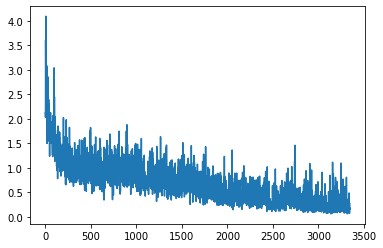

In [ ]:
import matplotlib.pyplot as plt
plt.plot(a)

## Actividad 5:
- Se puede ver el grafico de como disminuye la perdida. Se ve bastante inestable la perdida y puede ser por el force teaching
- Con la antencion se deberia poder disminuir esta inestabilidad

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
teacher_forcing_ratio = 0.5


def train_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def evaluate_attention(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_human, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_machine.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def trainIters_attention(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attention(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses)
    return plot_losses

In [ ]:
num_trainable_parameters(encoder1)+num_trainable_parameters(attn_decoder1)

953400

## Actividad 6
Tiene `953400` parametros entrenables el modelo
- Los tamaños de origen y destino no cambian. 15 y 8 respectivamente

0m 33s (- 7m 21s) (1000 7%) 1.7066
1m 6s (- 6m 36s) (2000 14%) 1.2459
1m 38s (- 6m 0s) (3000 21%) 0.9911
2m 10s (- 5m 26s) (4000 28%) 0.7961
2m 42s (- 4m 52s) (5000 35%) 0.6728
3m 15s (- 4m 20s) (6000 42%) 0.5626
3m 47s (- 3m 47s) (7000 50%) 0.4391
4m 19s (- 3m 14s) (8000 57%) 0.4468
4m 52s (- 2m 42s) (9000 64%) 0.5072
5m 24s (- 2m 9s) (10000 71%) 0.4223
5m 56s (- 1m 37s) (11000 78%) 0.4345
6m 27s (- 1m 4s) (12000 85%) 0.3041
7m 0s (- 0m 32s) (13000 92%) 0.2605
7m 32s (- 0m 0s) (14000 100%) 0.2777


<Figure size 432x288 with 0 Axes>

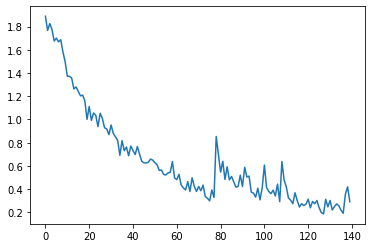

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_human.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_machine.n_words, dropout_p=0.1).to(device)

plot_losses = trainIters_attention(encoder1, attn_decoder1, 14000, print_every=1000)

## Actividad 7
- Se ve mucho mas estable la perdida que en el caso sin atencion. Tiene sentido que exista menos confusion al tratar de asignar los pesos si existe una atencion que facilita esta configuracion. 
- Tuvo una velocidad de convergencia mucho mas grande

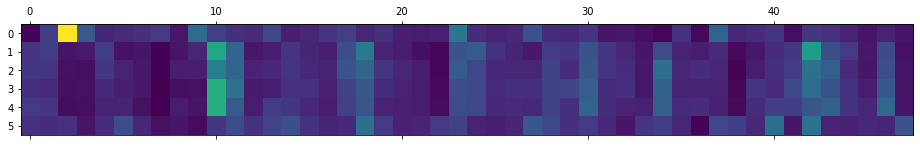

In [ ]:
output_words, attentions = evaluate_attention(
    encoder1, attn_decoder1, "jump thrice and look")
plt.matshow(attentions.numpy())

input = turn opposite right thrice and turn opposite left
output = I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
input = run right twice after walk right twice
output = I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>


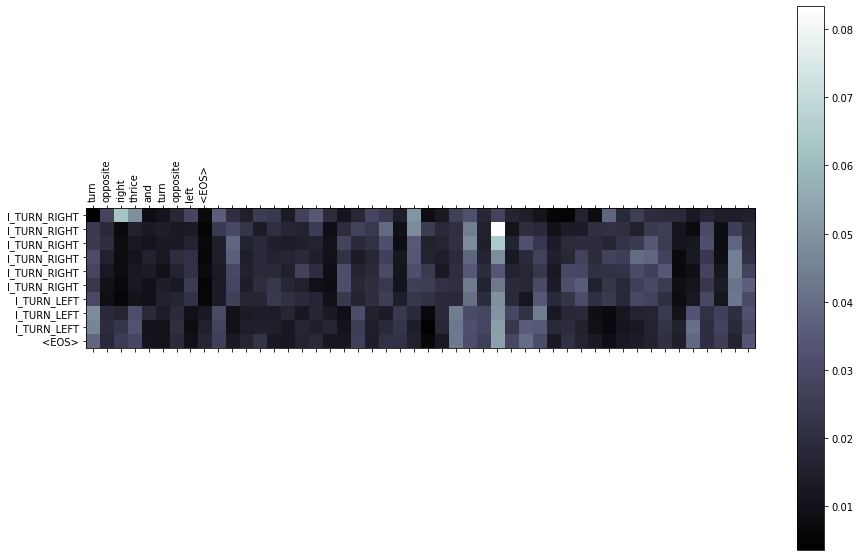

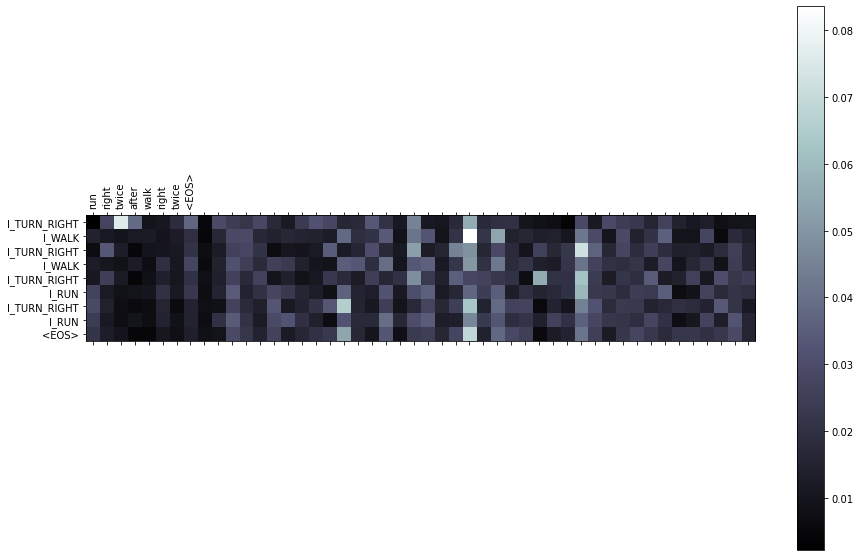

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate_attention(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("turn opposite right thrice and turn opposite left")
evaluateAndShowAttention("run right twice after walk right twice")

## Actividad 8
Se pueden ver las matrizes de los coeficientes de atencion de las dos primeras instancias del test. 
-  Es interesante que 'run' tenga poca antencion al inicia de la oracion. Es posbile que pocas oracions de entrenamiento inicieon con 'run'
- Se puede ver una relacion temporal como entre las palabras del humano y la maquina.
- Existen valores que tuvieron bastante atencion pero no fueron elegidos o preferidos para estos resultados.